In [1]:
suppressPackageStartupMessages({
    library(SummarizedExperiment)
    library(DESeq2)
    library(tidyverse)
    library(data.table)
    library(EnhancedVolcano)
    })


if (!dir.exists('../_m')) {
  dir.create('../_m', showWarnings = TRUE, recursive = TRUE)
}
setwd('../_m')

In [2]:
#load('/dcs05/lieber/apaquola/users/alorenzetti/xdp_striatal_organoids_RNA-seq/speaqeasy_star/_m/count_objects/rse_gene_Jlab_experiment_n53.Rdata')

In [3]:
#load('/dcs05/lieber/apaquola/users/alorenzetti/xdp_striatal_organoids_RNA-seq/speaqeasy_star/_m/count_objects/rse_gene_Jlab_experiment_n53.Rdata')
#load('/dcs05/lieber/apaquola/users/alorenzetti/xdp_striatal_organoids_RNA-seq/speaqeasy_star/_m/count_objects/rse_exon_Jlab_experiment_n53.Rdata')

In [4]:
rdata_files <- Sys.glob('/dcs05/lieber/apaquola/users/alorenzetti/xdp_striatal_organoids_RNA-seq/speaqeasy_star/_m/count_objects/*.Rdata')
rdata_files

#load(rdata_files[1]) #exons
load(rdata_files[2]) #genes
#load(rdata_files[3]) # junctions
#load(rdata_files[4]) # transcripts 


[1] "/dcs05/lieber/apaquola/users/alorenzetti/xdp_striatal_organoids_RNA-seq/speaqeasy_star/_m/count_objects/rse_exon_Jlab_experiment_n53.Rdata"
[2] "/dcs05/lieber/apaquola/users/alorenzetti/xdp_striatal_organoids_RNA-seq/speaqeasy_star/_m/count_objects/rse_gene_Jlab_experiment_n53.Rdata"
[3] "/dcs05/lieber/apaquola/users/alorenzetti/xdp_striatal_organoids_RNA-seq/speaqeasy_star/_m/count_objects/rse_jx_Jlab_experiment_n53.Rdata"  
[4] "/dcs05/lieber/apaquola/users/alorenzetti/xdp_striatal_organoids_RNA-seq/speaqeasy_star/_m/count_objects/rse_tx_Jlab_experiment_n53.Rdata"

In [5]:
rm(rdata_files)
rse_obj <- ls()
rse_obj
#ls()

[1] "rse_gene"

In [6]:
# new DE model: control+deltasva VS XDP

In [7]:
metadata = fread('/dcs05/lieber/apaquola/users/alorenzetti/xdp_striatal_organoids_RNA-seq/analysis_speaqeasy/metadata/_m/XDP_striatal_organoids_metadata.tsv') %>%
                filter(RIN >= 6) %>%
                dplyr::select(1:11) %>%
                #mutate(new_Cell_line = ifelse(Cell_line == 'Control' | Cell_line == 'DELTA-SVA-XDP', 'Control','XDP')) %>%
                #convert these categorical variables (columns) to factor
                mutate_at(vars(Differentiation_cohort, iPSC_line, Cell_line, Sex, Day_of_Maturation, Kit, Disease_Status, individual), factor)

head(metadata)
table(metadata$Cell_line)


Differentiation_cohort Sample iPSC_line    Cell_line     Sex 
1 A                      1N     33113.2I     Control       Male
2 A                      2N     33109.2G     XDP           Male
3 A                      3N     33109.2G-1A4 DELTA-SVA-XDP Male
4 A                      4N     33109.2G-2F2 DELTA-SVA-XDP Male
5 A                      5N     33113.2I     Control       Male
6 A                      6N     33109.2G     XDP           Male
  Day_of_Maturation RIN Kit        Disease_Status individual SAMPLE_ID
1 30                8.7 Zymo_R2062 healthy        33113      1N       
2 30                8.0 Zymo_R2062 patient        33109      2N       
3 30                9.0 Zymo_R2062 healthy        33109      3N       
4 30                8.8 Zymo_R2062 healthy        33109      4N       
5 60                7.6 Zymo_R2062 healthy        33113      5N       
6 60                7.6 Zymo_R2062 patient        33109      6N


Carrier-Control  Carrier-Mutant         Control   DELTA-SVA-XDP             XDP 
              2               7              12              15              11 

In [8]:
merge_with_metadata = function(rse, metadata_df)
{
    # Return a new_rse object such that:
    #  (1) new_rse contains only the samples present in both rse and metadata_df
    #  (2) colData(new_rse) contains information from both colData(rse) and metadata_df 
    
    x = as_tibble(colData(rse))
    y = as_tibble(metadata_df)
    
    new_coldata = x  %>% 
                    inner_join(y, by=c("SAMPLE_ID" = "Sample"))
    
    new_rse = rse[, new_coldata$SAMPLE_ID]
    
    stopifnot(dim(new_coldata)[1] == dim(new_rse)[2])
    stopifnot(all(colnames(new_rse) == new_coldata$SAMPLE_ID))
    
    colData(new_rse) = DataFrame(new_coldata)
    colnames(new_rse) = new_coldata$SAMPLE_ID
    return(new_rse)
}
    
    


In [9]:
deseq2_analysis = function(rse, rse_type, sample_ids, design, analysis_name)
{
    # Parameters:
    #  rse: RangedSummarizedExperiment
    #  sample_ids: a list of sample ids (subset of colData(rse))
    #  design: linear model formula for DE analysis. Covariates are in colData(rse)
    #  analysis_name: name of analysis. This is also a folder under _m where to save the analysis results
    #
    # Do a DESeq2 analysis on rse object <rse>, considering only <sample_ids>, and applying model <design>
    
    
    # The last variable in the design formula is the one that DESeq2 calculates DE with. We save its name in de_variable 
    # so we can use it later.
    stopifnot(is_formula(design))
    de_variable = all.vars(design) %>% 
                                    tail(n=1)
    
    # Subset rse to samples of interest
    rse_subset = rse[, sample_ids]
    
    # See if type of counts is double or integer
    stopifnot(type(assays(rse)[['counts']]) %in% c('double', 'integer'))
    
    # If type of counts is double, round and convert to integer
    # This happens with kallisto transcript quantification, which has non-integer counts.
    # When quantifying transcripts with kallisto, it is OK to round the counts. 
    # When quantifying genes with kallisto (combining multiple transcripts from the same gene), one needs to load the quantifications with tximport,
    # which takes into account average transcript length. (It is not the case here with speaqeasy output).
    #if(type(assays(rse)[['counts']]) == 'double')
    #{
    #    assays(rse)[['counts']] = round(assays(rse)[['counts']])
    #    type(assays(rse)[['counts']]) = 'integer'
    #}
    
    ##TEST only with 5000 features
    #dds <- DESeqDataSet(rse_subset, design = design)
    #rse_subset <- rse_subset[1:1000,]
    
    # ifelse(length(rse_subset@assays) > 1, 
    #            assays(rse_subset)$tpm <- NULL,
    #            'ok!')
           
    
    #assays(rse_subset)$tpm <- NULL
   
    #create a deseq2 obj
    dds <- DESeqDataSet(rse_subset, design = design)
    
    # Improved gene filtering based on filterByExpr logic
    min.count <- 10
    min.total.count <- 15
    large.n <- 10
    min.prop <- 0.7
    
    # Get raw counts
    counts_matrix <- counts(dds)
    
    # Calculate minimum sample size based on design
    h <- hat(model.matrix(design, colData(dds)))
    min_sample_size <- 1/max(h)
    
    # Adjust minimum sample size for large sample sizes
    if(min_sample_size > large.n) {
        min_sample_size <- large.n + (min_sample_size - large.n) * min.prop
    }
    
    # Apply filters:
    # 1. Check which genes have at least min.count in sufficient samples
    keep_min_samples <- rowSums(counts_matrix >= min.count) >= min_sample_size
    # 2. Check total counts threshold
    keep_total <- rowSums(counts_matrix) >= min.total.count
    # Combine filters
    genes_to_keep <- keep_min_samples & keep_total
    
    # Filter the DESeq dataset
    # # Removed lowly expressed genes
    # genes_to_keep <- rowSums(counts(dds)) >= 2
    dds <- dds[genes_to_keep,]
    
    # Calculate DE
    dds <- estimateSizeFactors(dds)
    dds <- DESeq(dds)

    # Get results
    #res <- results(dds)
    res <- results(dds, name=paste0(resultsNames(dds)[length(resultsNames(dds))]))
    # or to shrink log fold changes association with condition:    
#    res <- lfcShrink(dds, coef=paste0(resultsNames(dds)[length(resultsNames(dds))]),type='apeglm')

    
    
    
    
    #Print results
    results(dds, alpha=0.05, lfcThreshold=0) %>% 
                                            summary() # fdr < 0.05 & no FC
    results(dds, alpha=0.1, lfcThreshold=0) %>% 
                                            summary() # fdr < 0.1 & no FC
    ####################
    print('raw pval')
    results(dds, alpha=0.05, lfcThreshold=0, 
            pAdjustMethod = 'none') %>% 
                                    summary()# raw p-value < 0.05 & no FC
    
    
    
    # get gene annotation from rse
    annotated_genes = rowData(dds) %>% 
                                    as.data.frame %>% 
                                    rownames_to_column(var = "ROW_INDEX") #%>% 
                #                    as_tibble()
    
    # Order results by pvalue and merge with gene annotation
    annotated_results = res[order(res$pvalue),] %>% 
                                                as.data.frame %>% 
                                                rownames_to_column(var = "ROW_INDEX") %>% #as_tibble() %>% 
                                                left_join(annotated_genes, by="ROW_INDEX")

    
    #mkdir -p analysis name
    dir.create(analysis_name, showWarnings = TRUE, recursive = TRUE)

    #save de results here
    save(dds, file=paste0(analysis_name, '/', rse_type,'_dds.Rdata'))
    fwrite(annotated_results, file=paste0(analysis_name, '/', rse_type,'_deseq2_results.tsv'),sep='\t')
    #create a empty file with the design of the deseq2 linear model
    file.create(paste0(analysis_name, '/~',sample_select$design[1]))

    
    
        
    top_gene = annotated_results[1,]$ROW_INDEX
    top_genesymbol = annotated_results[1,]$Symbol
    top_logfc = format(annotated_results[1,]$log2FoldChange, nsmall = 2)
    
        
    
    # plot top gene boxplot so we know the direction of fold change
    p1 = plotCounts(dds, gene=top_gene, intgroup=de_variable, returnData=TRUE) %>%
               #as_tibble() %>% 
               ggplot(aes(y=.data[['count']], x=.data[[de_variable]])) + 
               geom_boxplot(fill="darkgray") + 
               geom_jitter() + 
               scale_y_log10() + 
               ylab('log10(Normalized Counts)') + 
               ggtitle(paste0(top_gene,'\n', top_genesymbol, '\nlog2FC= ',top_logfc)) +
               theme_classic()

    ggsave(paste0(analysis_name,'/',rse_type,'_top_DE_feature_boxplot.pdf'), p1)
    
    plot(p1)
    
    p2 = EnhancedVolcano(annotated_results,
                lab = annotated_results$Symbol,
                x = 'log2FoldChange',
                y = 'padj',
                pCutoff = 0.05,
                FCcutoff = 0.0,
                title = analysis_name
               ) 
    
    ggsave(paste0(analysis_name,'/',rse_type,'_enhancedvolcano_fdr005.pdf'), p2)
    
    plot(p2)

    return(annotated_results)
}
    
    

In [10]:
# Load deseq2 samples per each deseq2 model/design

###  remove the coments if you want to select ONLY model v7 Mature_organoids_all_comparison_design1_deseq2

In [11]:
deseq2_version <- fread('../../metadata/de_models/_m/deseq2_models_description.tsv') #%>% filter(version == 'v7')

design_version <- deseq2_version$design

analysis_version <- deseq2_version$model

deseq2_model <- fread('../../metadata/de_models/_m/de_comparisons.tsv') #%>% filter(deseq2 == 'Mature_organoids_all_comparison_design1_deseq2')

In [12]:
unique(deseq2_model$deseq2)

[1] "Big_Model_All_Sample_Comparison_design1_deseq2"                                            
 [2] "Big_Model_All_Sample_Comparison_design2_deseq2"                                            
 [3] "Big_Model_no_individual_no_differentiation_cohort_All_Sample_Comparison_deseq2"            
 [4] "Big_Model_Male_Comparison_design1_deseq2"                                                  
 [5] "Big_Model_Male_Comparison_design2_deseq2"                                                  
 [6] "Big_Model_no_individual_no_differentiation_cohort_male_Comparison_deseq2"                  
 [7] "Mature_organoids_all_comparison_design1_deseq2"                                            
 [8] "Mature_organoids_all_comparison_design2_deseq2"                                            
 [9] "no_individual_no_differentiation_cohort_Mature_organoids_all_deseq2"                       
[10] "Mature_organoids_male_comparison_design1_deseq2"                                           
[11] "Mature_organoids_male_comparison_design2_deseq2"                                           
[12] "no_individual_no_differentiation_cohort_Mature_organoids_male_comparison_deseq2"           
[13] "Big_Model_All_Sample_nodeltaSVA_Comparison_design1_deseq2"                                 
[14] "Big_Model_All_Sample_nodeltaSVA_Comparison_design2_deseq2"                                 
[15] "Mature_organoids_male__nodeltaSVA_comparison_deseq2"                                       
[16] "Mature_organoids_male_no_individual_no_differentiation_cohort_nodeltaSVA_comparison_deseq2"
[17] "Mature_organoids_DELTASVA_comparison_design1_deseq2"                                       
[18] "Mature_organoids_DELTASVA_comparison_design2_deseq2"                                       
[19] "Mature_organoids_DELTASVA_male_comparison_design1_deseq2"                                  
[20] "Mature_organoids_DELTASVA_male_comparison_design2_deseq2"                                  
[21] "no_individual_no_differentiation_cohort_DELTASVA_Mature_organoids_male_comparison_deseq2"  
[22] "Big_Model_All_Sample_DELTASVA_Comparison_design1_deseq2"                                   
[23] "Big_Model_All_Sample_DELTASVA_Comparison_design2_deseq2"                                   
[24] "Mature_organoids_male__DELTASVA_comparison_deseq2"                                         
[25] "Mature_organoids_male_no_individual_no_differentiation_cohort_DELTASVA_comparison_deseq2"  
[26] "Day30_All_Male_Pairwise_controlxdp_deseq2"                                                 
[27] "Day30_All_Male_Pairwise_controldelta_deseq2"                                               
[28] "Day30_All_Male_Pairwise_deltaxdp_deseq2"                                                   
[29] "Day60_All_Male_Pairwise_controlxdp_deseq2"                                                 
[30] "Day60_All_Male_Pairwise_controldelta_deseq2"                                               
[31] "Day60_All_Male_Pairwise_deltaxdp_deseq2"                                                   
[32] "Day90_All_Male_Pairwise_controlxdp_deseq2"                                                 
[33] "Day90_All_Male_Pairwise_controldelta_deseq2"                                               
[34] "Day90_All_Male_Pairwise_deltaxdp_deseq2"                                                   
[35] "Day120_All_Male_Pairwise_controlxdp_deseq2"                                                
[36] "Day120_All_Male_Pairwise_controldelta_deseq2"                                              
[37] "Day120_All_Male_Pairwise_deltaxdp_deseq2"                                                  
[38] "Mature_organoids_male__ControlxDELTASVA_fullmodel_deseq2"                                  
[39] "Mature_organoids_male__ControlxDELTASVA_smallmodel_deseq2"

[1] "gene - Mature_organoids_all_comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



12 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 28228 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.0035%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 28228 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.0071%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 28228 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1146, 4.1%
LFC < 0 (down)     : 596, 2.1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


Saving 7 x 7 in image


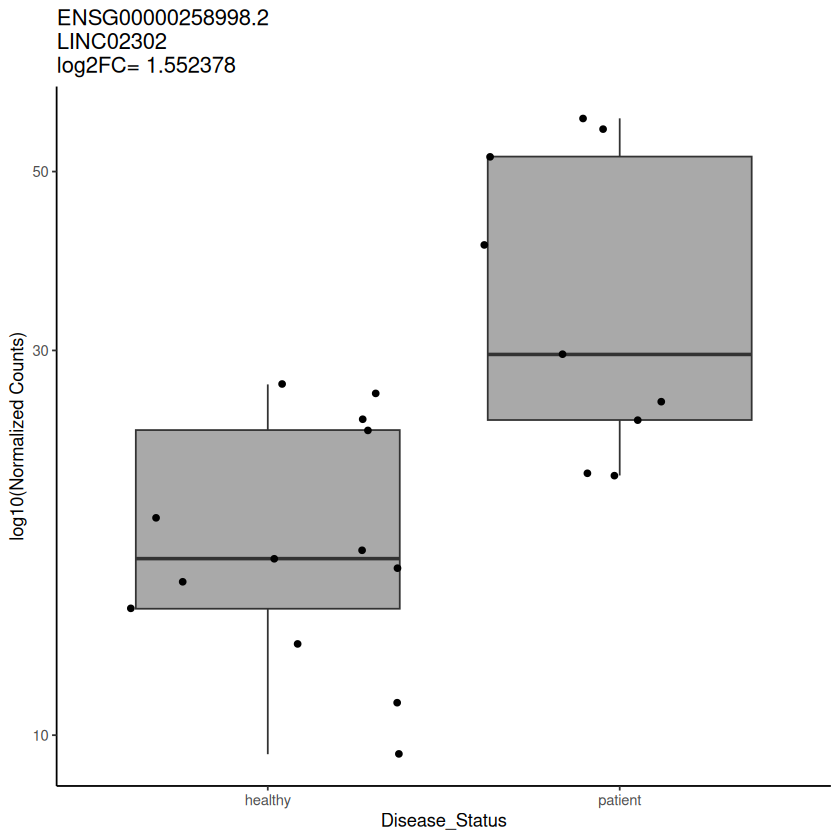

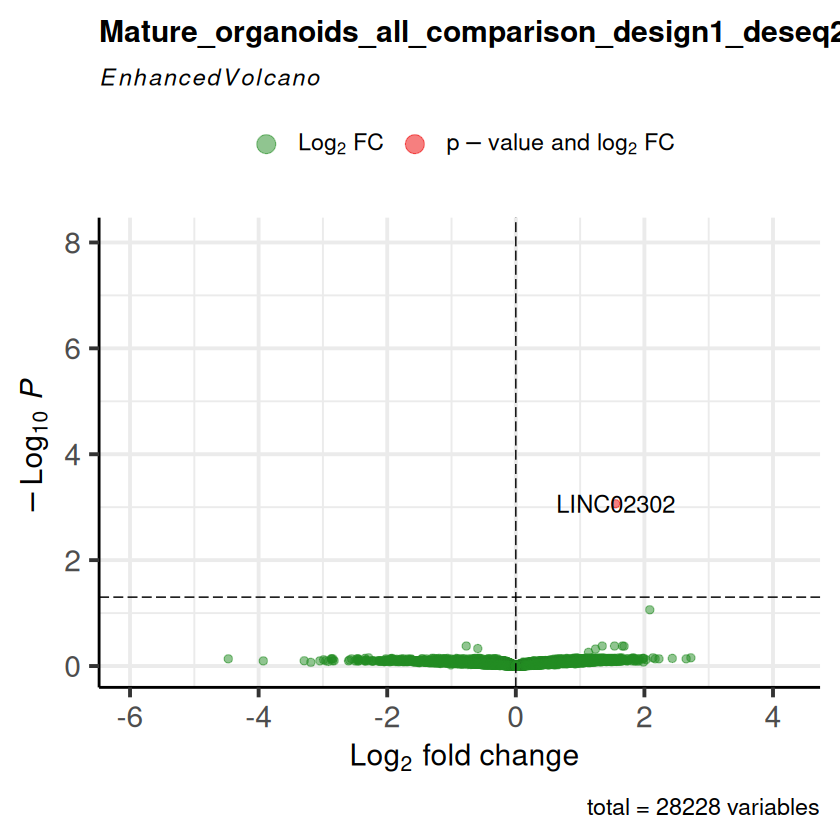

In [13]:
for (rse_var in rse_obj){

    rse_class <- ifelse(grepl('rse_gene',rse_var), 'gene',
                       ifelse(grepl('rse_exon',rse_var), 'exon', 
                            ifelse(grepl('rse_jx',rse_var), 'junction',
                                'transcript')
                              )
                        )

    annotated_rse_obj = merge_with_metadata(rse = get(rse_var), 
                                            metadata_df = metadata)


    for(model in c("Mature_organoids_all_comparison_design1_deseq2")){

        sample_select <- deseq2_model %>%
                                        filter(deseq2 == model)

        sample_ids = colData(annotated_rse_obj) %>% 
                                                as_tibble() %>% 
                                                filter(SAMPLE_ID %in% sample_select$Sample) %>% 
                                                pluck('SAMPLE_ID')

        print(paste0(rse_class, ' - ', sample_select$deseq2[1]))


        a = deseq2_analysis(rse = annotated_rse_obj, 
                            rse_type = rse_class, #gene, kunction or exon rse_obj?
                            sample_ids = sample_ids,
                            #design = ~Cell_line, 
                            design = formula(paste0('~',sample_select$design[1])),
                            #design = ~RIN + Day_of_Maturation + Kit + new_Cell_line, 
                            analysis_name=sample_select$deseq2[1])

        }


}

[1] "gene - Big_Model_All_Sample_Comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



28 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 29390 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2, 0.0068%
LFC < 0 (down)     : 1, 0.0034%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 29390 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.0068%
LFC < 0 (down)     : 2, 0.0068%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 29390 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 487, 1.7%
LFC < 0 (down)     : 530, 1.8%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


Saving 7 x 7 in image


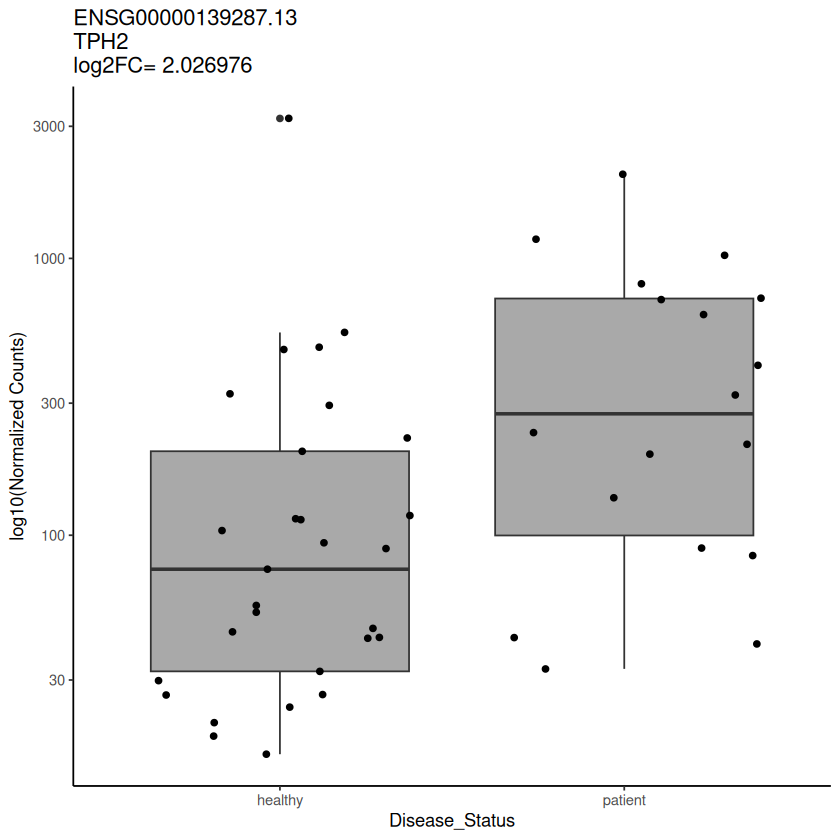

[1] "gene - Big_Model_All_Sample_Comparison_design2_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



20 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 29390 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 1, 0.0034%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 29390 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 1, 0.0034%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 29390 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 393, 1.3%
LFC < 0 (down)     : 593, 2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


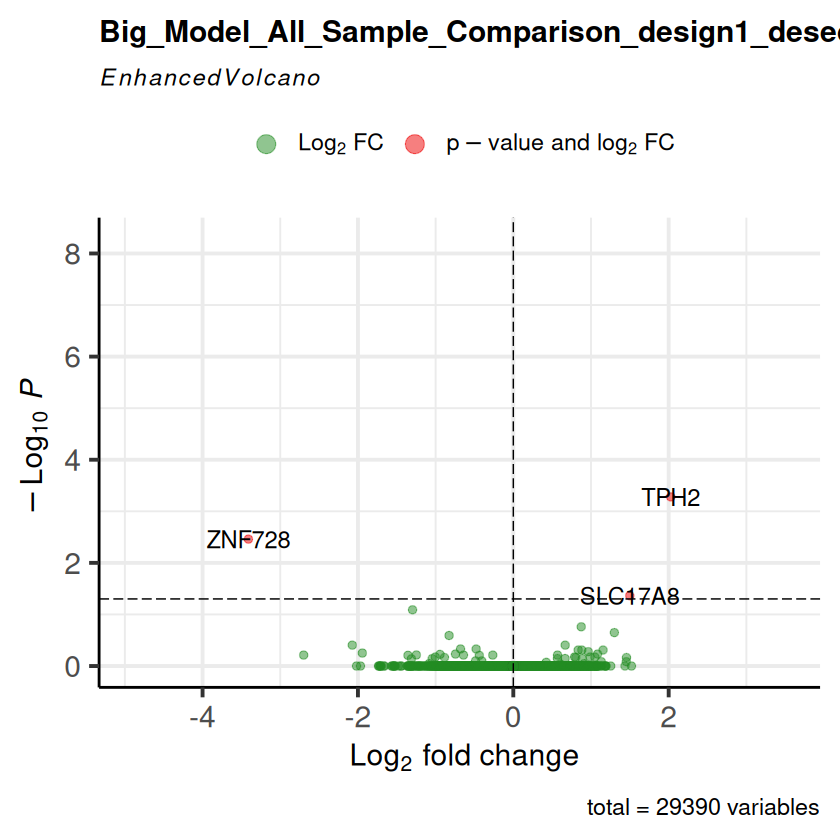

Saving 7 x 7 in image


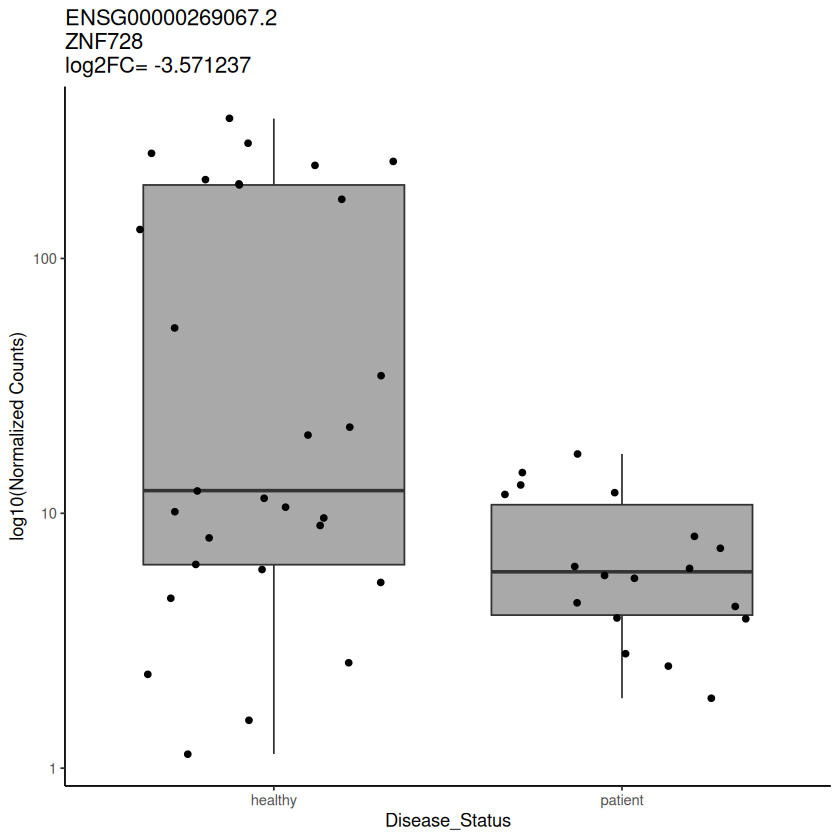

[1] "gene - Big_Model_no_individual_no_differentiation_cohort_All_Sample_Comparison_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



20 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 29390 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 1, 0.0034%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 29390 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 1, 0.0034%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 29390 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 393, 1.3%
LFC < 0 (down)     : 593, 2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


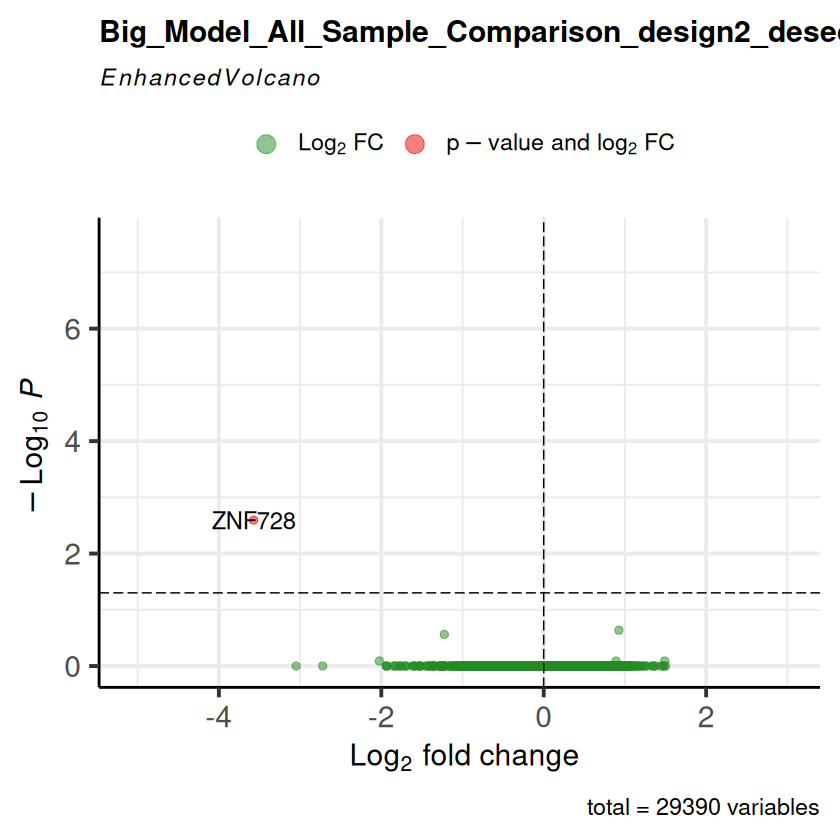

Saving 7 x 7 in image


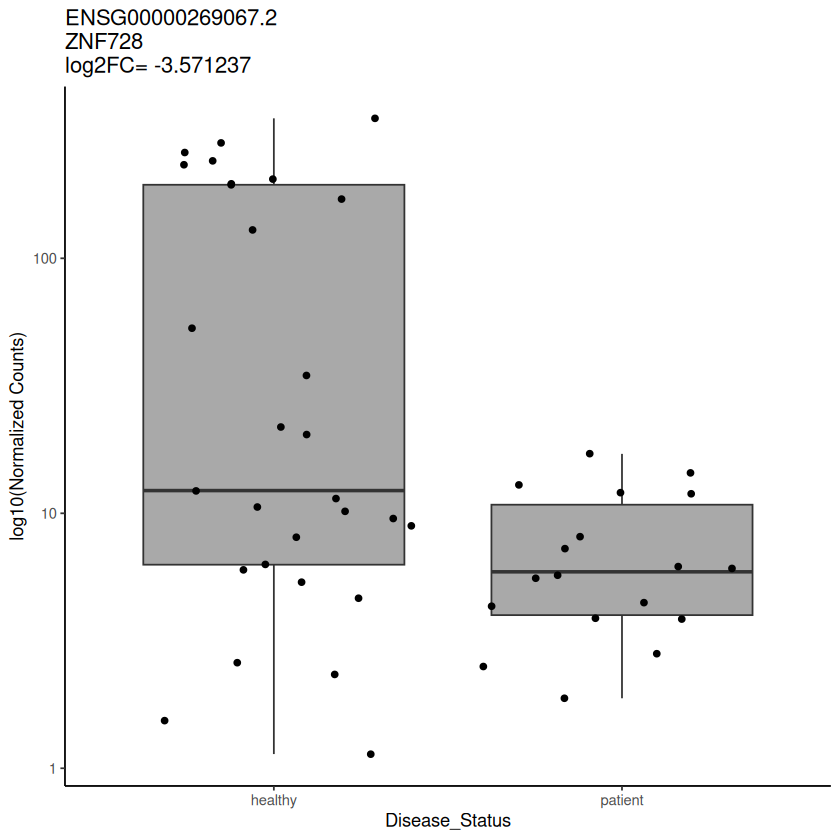

[1] "gene - Big_Model_Male_Comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



26 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 30526 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.0033%
LFC < 0 (down)     : 2, 0.0066%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 30526 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.0066%
LFC < 0 (down)     : 3, 0.0098%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 30526 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 552, 1.8%
LFC < 0 (down)     : 533, 1.7%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


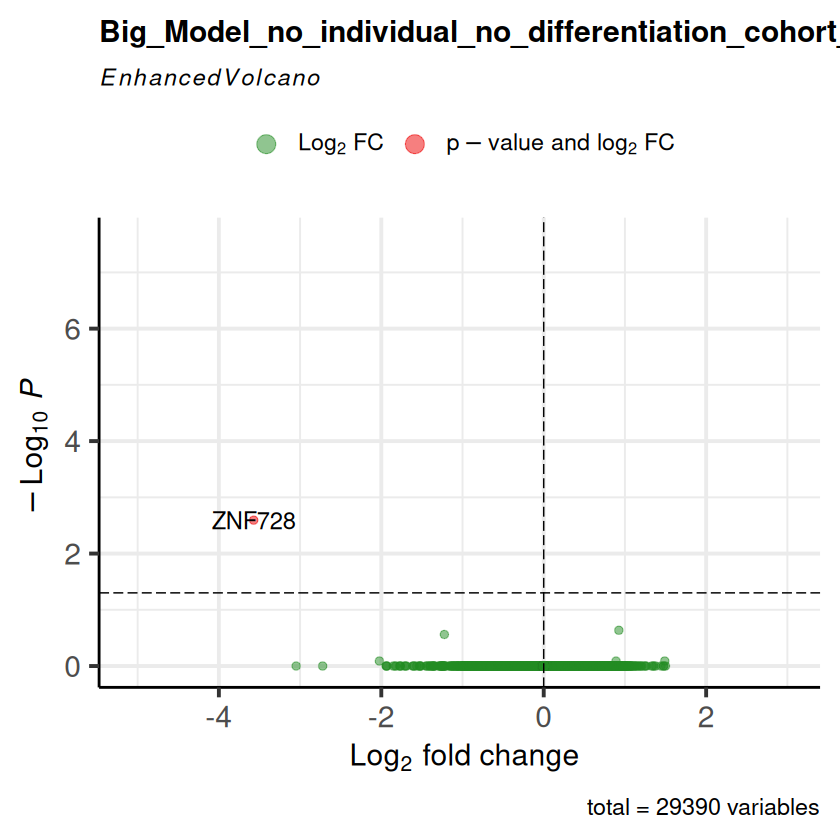

Saving 7 x 7 in image


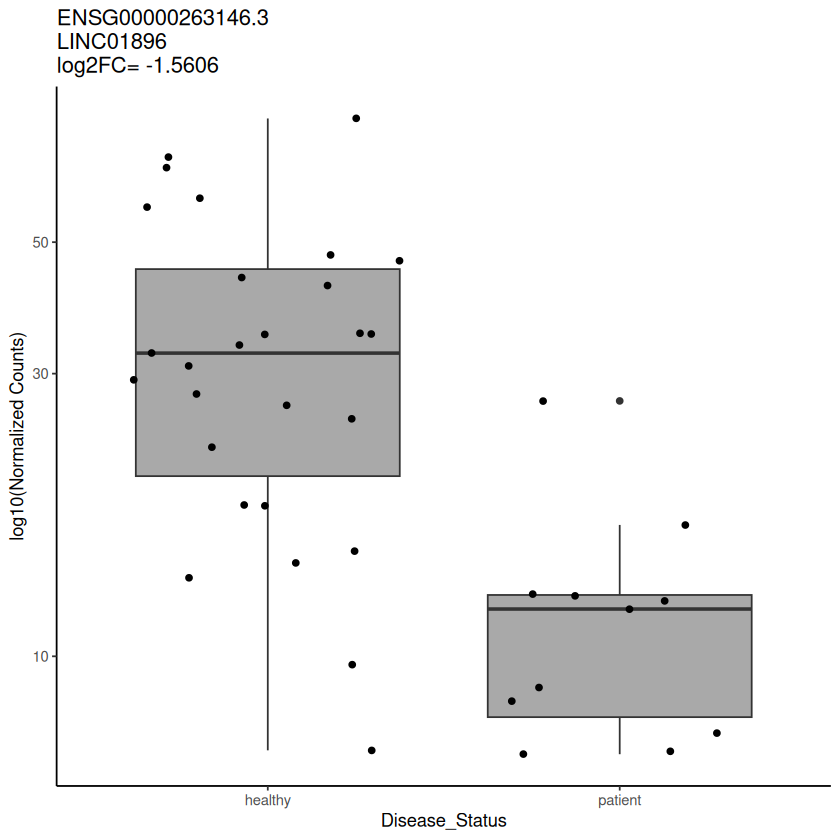

[1] "gene - Big_Model_Male_Comparison_design2_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



34 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 30526 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3, 0.0098%
LFC < 0 (down)     : 8, 0.026%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 30526 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4, 0.013%
LFC < 0 (down)     : 8, 0.026%
outliers [1]       : 0, 0%
low counts [2]     : 1184, 3.9%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 30526 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 535, 1.8%
LFC < 0 (down)     : 725, 2.4%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


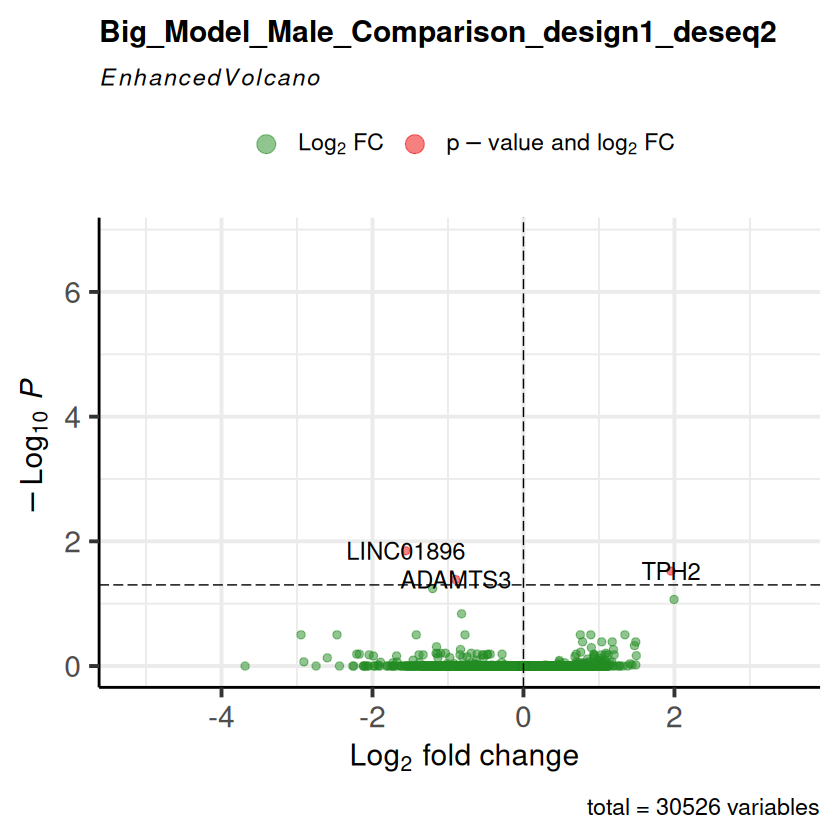

Saving 7 x 7 in image


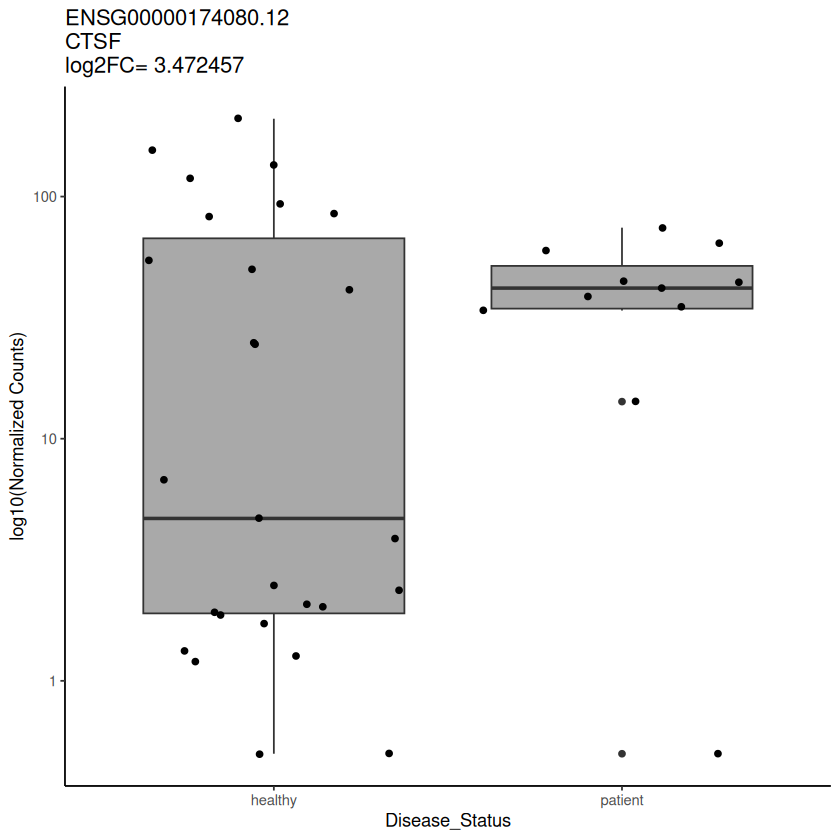

[1] "gene - Big_Model_no_individual_no_differentiation_cohort_male_Comparison_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



6 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 28841 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 28841 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 1, 0.0035%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 28841 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 339, 1.2%
LFC < 0 (down)     : 453, 1.6%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


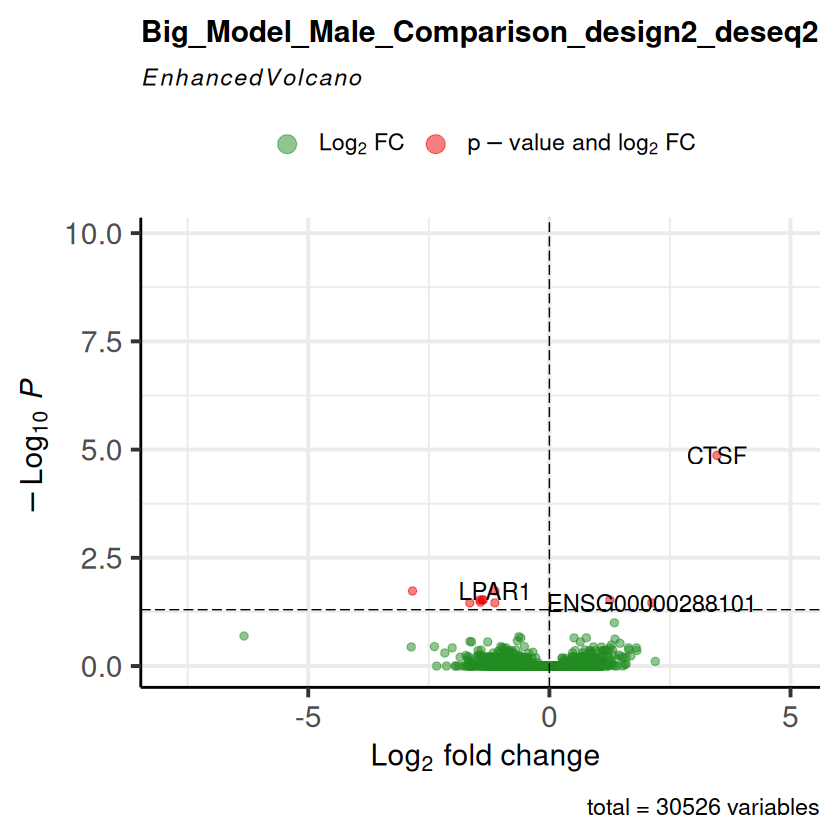

Saving 7 x 7 in image


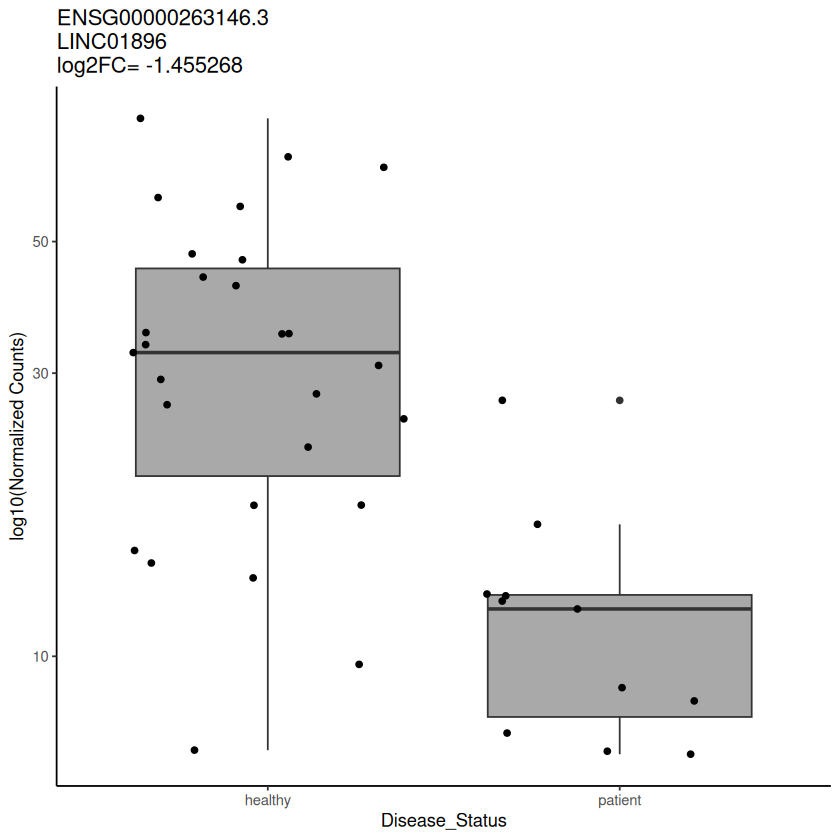

[1] "gene - Mature_organoids_all_comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



12 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 28228 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.0035%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 28228 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.0071%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 28228 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1146, 4.1%
LFC < 0 (down)     : 596, 2.1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Warning message in dir.create(analysis_name, showWarnings = TRUE, recursive = TRUE):
“'Mature_organoids_all_comparison_design1_deseq2' already exists”


Saving 7 x 7 in image


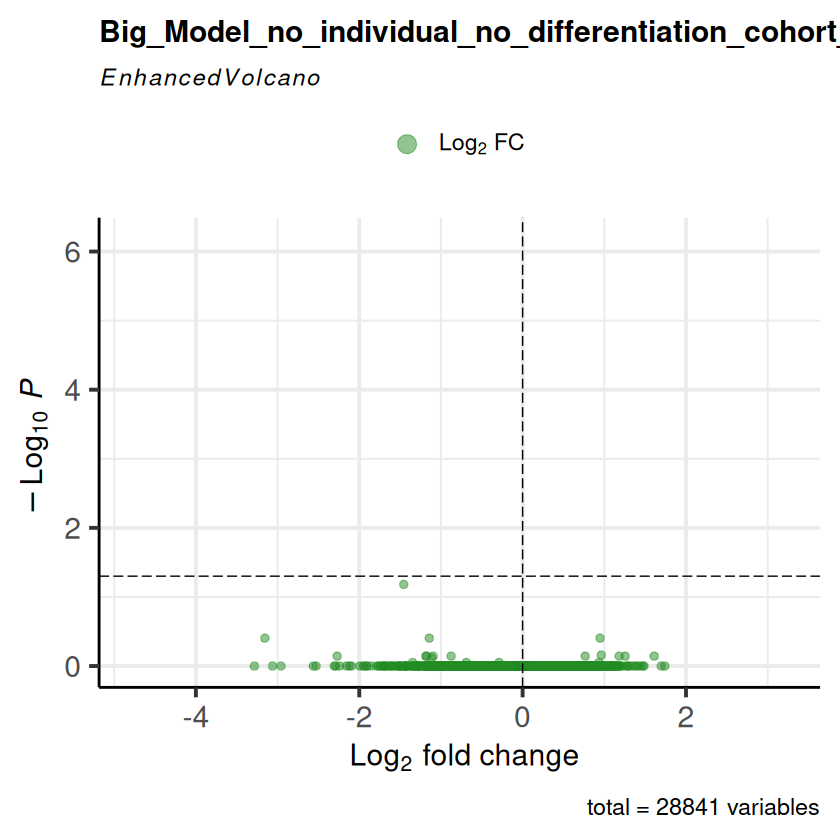

Saving 7 x 7 in image


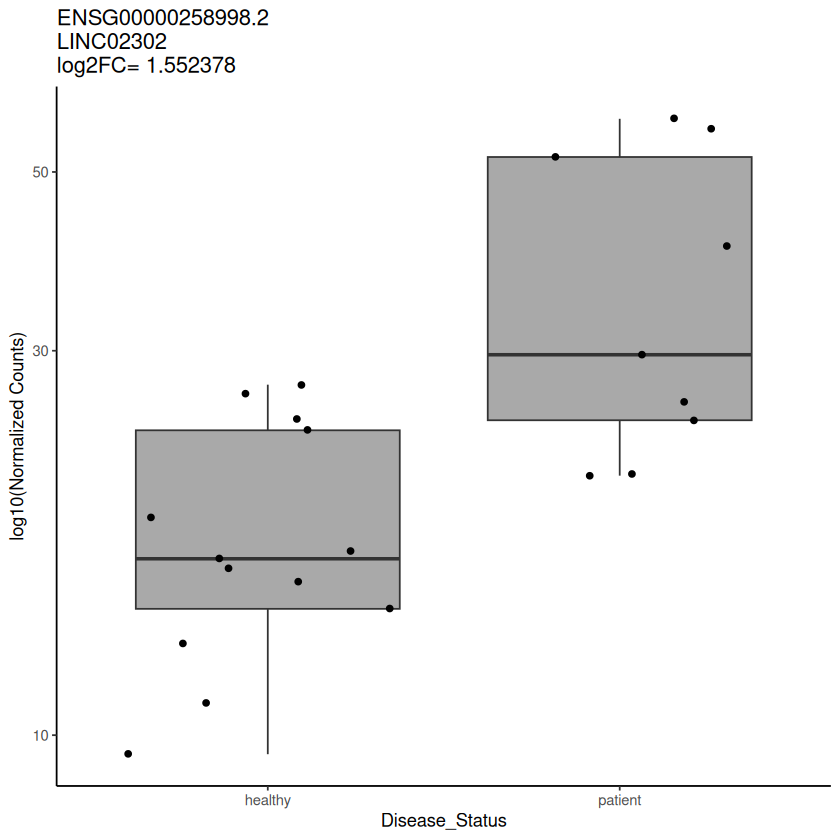

[1] "gene - Mature_organoids_all_comparison_design2_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 26541 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2, 0.0075%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26541 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.0075%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26541 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 948, 3.6%
LFC < 0 (down)     : 424, 1.6%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


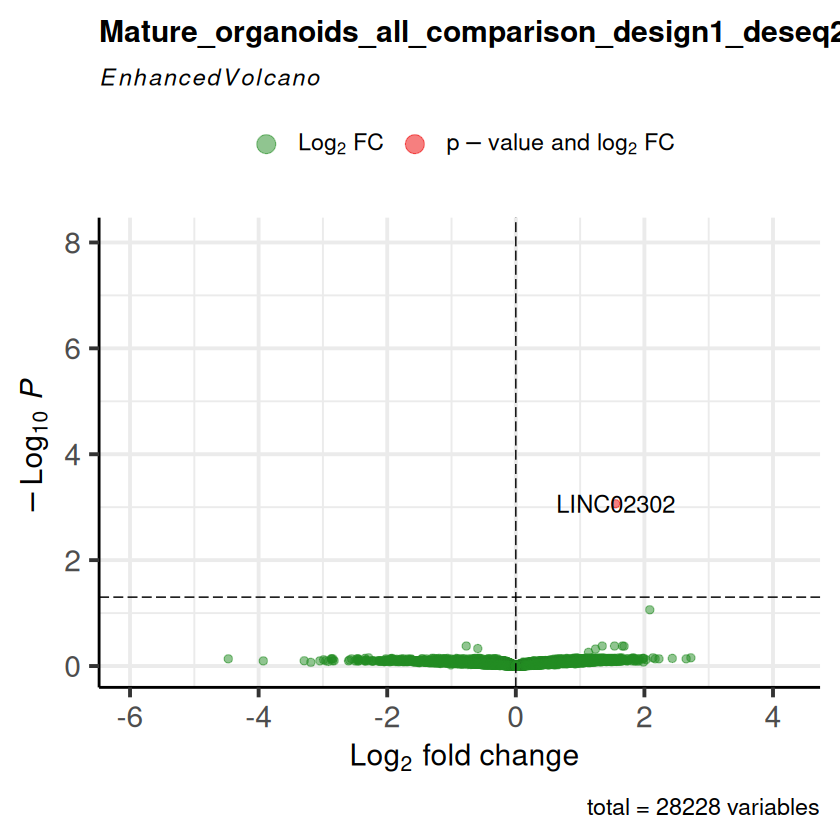

Saving 7 x 7 in image


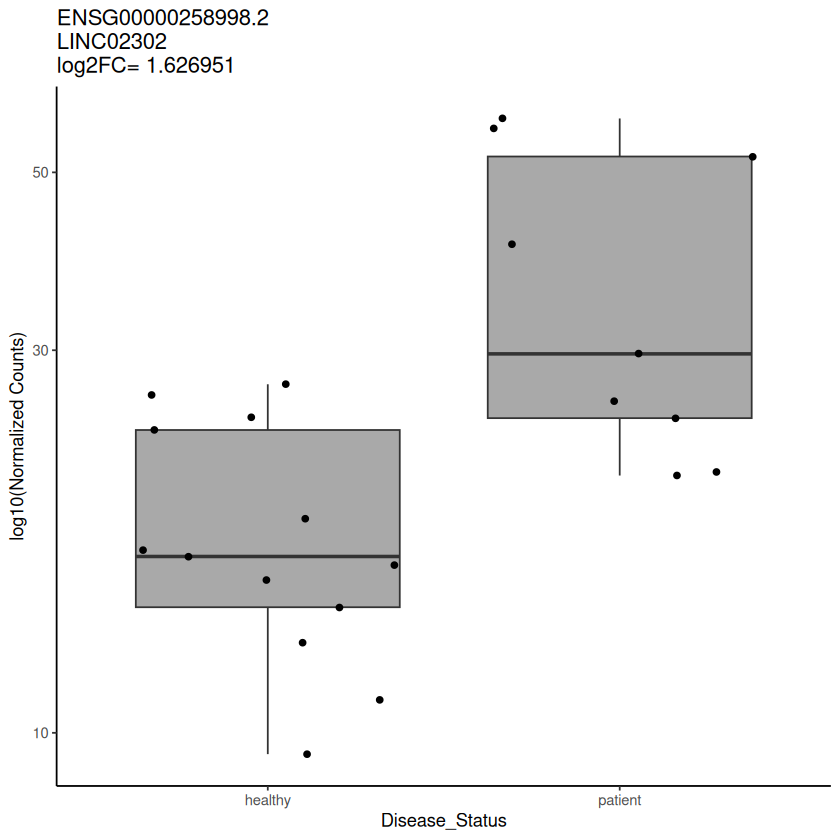

[1] "gene - no_individual_no_differentiation_cohort_Mature_organoids_all_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 26541 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2, 0.0075%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26541 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.0075%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26541 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 948, 3.6%
LFC < 0 (down)     : 424, 1.6%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


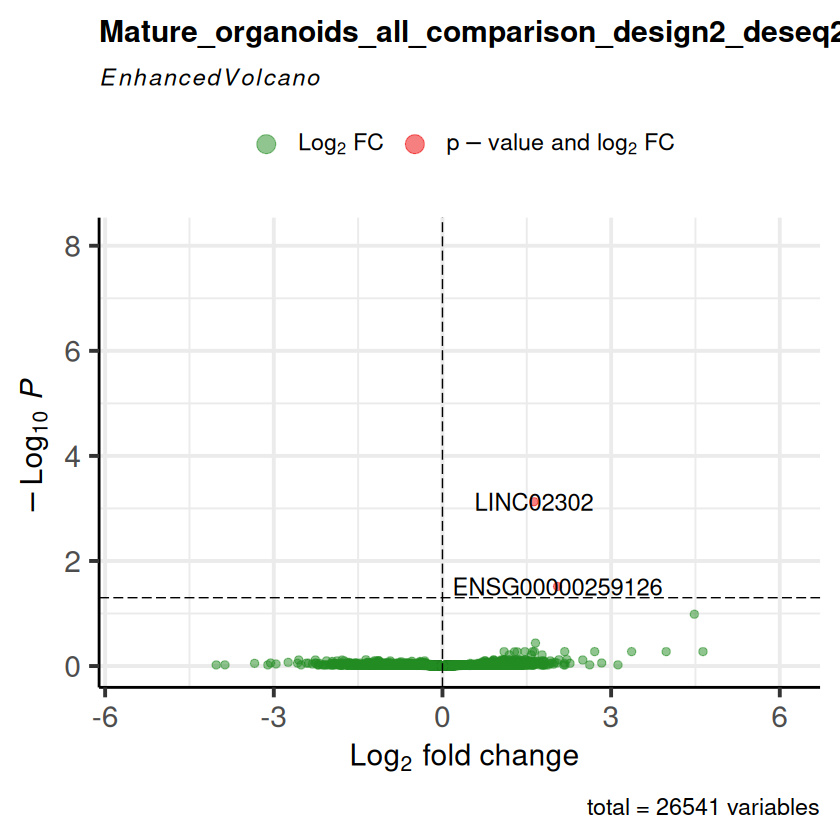

Saving 7 x 7 in image


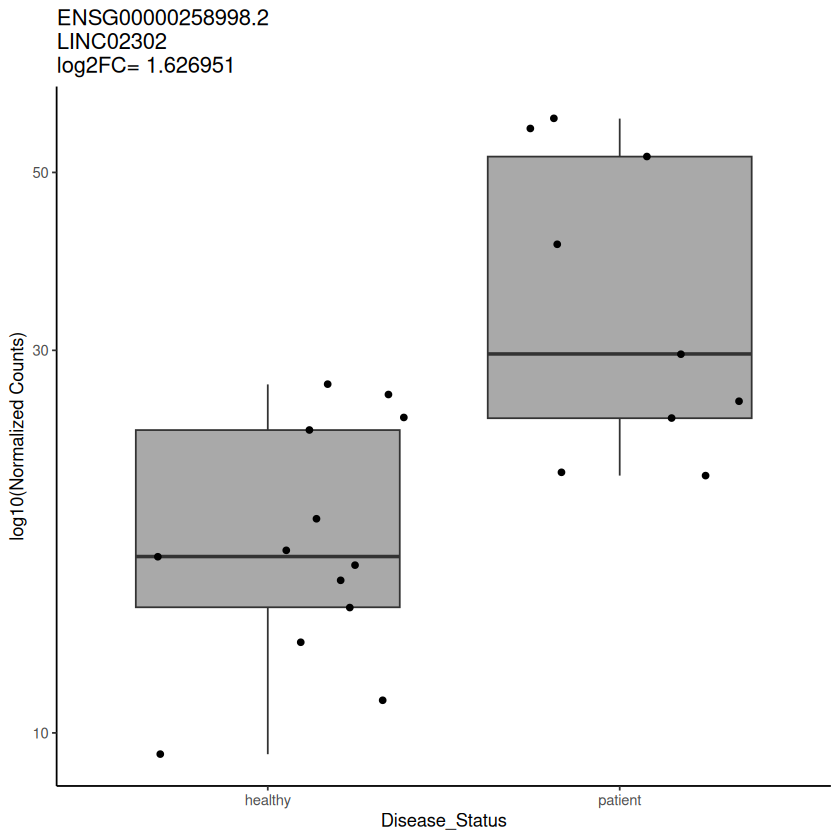

[1] "gene - Mature_organoids_male_comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



2 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 27586 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.0036%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 27586 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 7, 0.025%
LFC < 0 (down)     : 2, 0.0073%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 27586 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1596, 5.8%
LFC < 0 (down)     : 822, 3%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


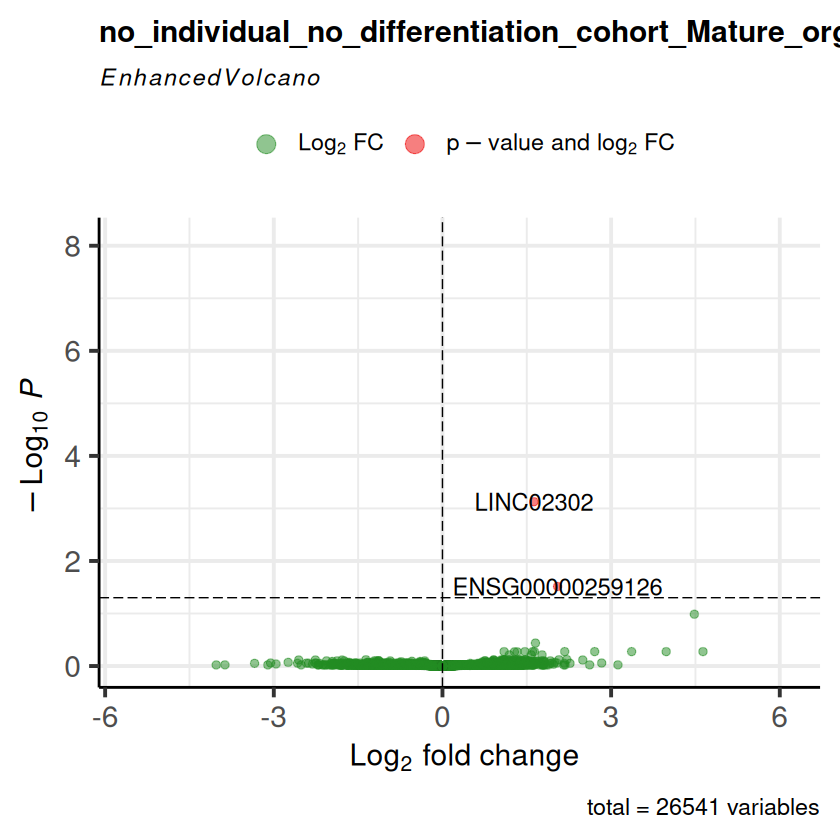

Saving 7 x 7 in image


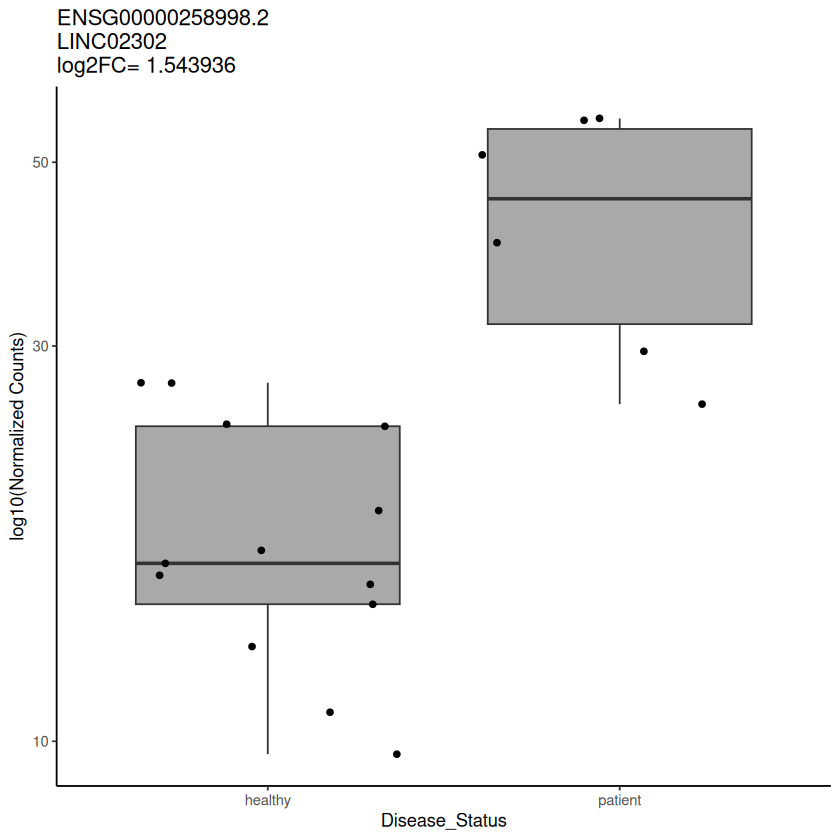

[1] "gene - Mature_organoids_male_comparison_design2_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



3 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 27586 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 27586 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 27586 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 741, 2.7%
LFC < 0 (down)     : 456, 1.7%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


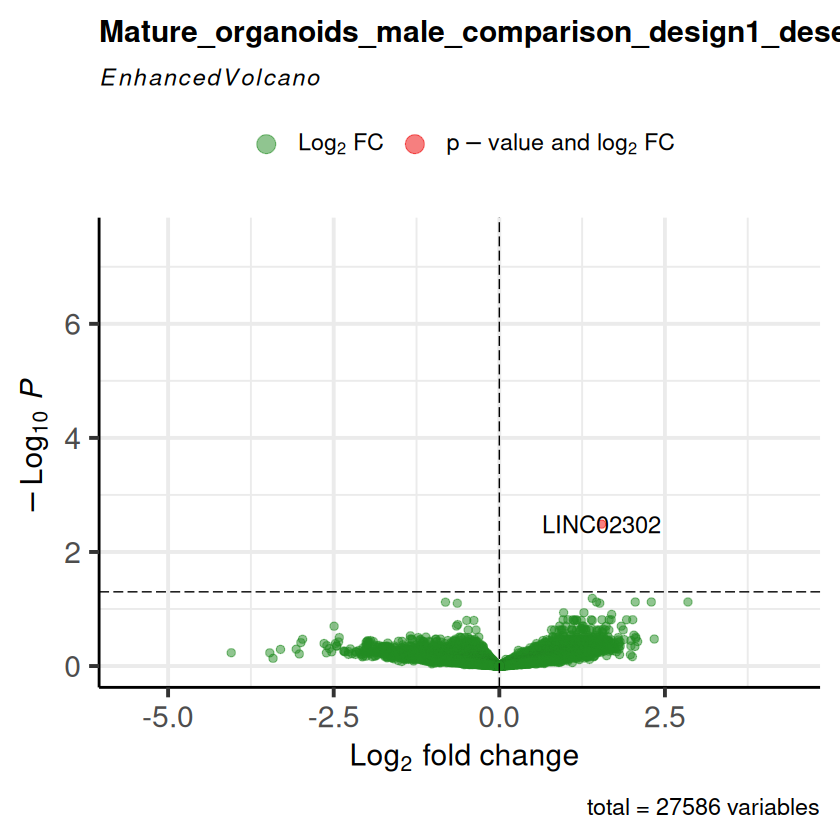

Saving 7 x 7 in image


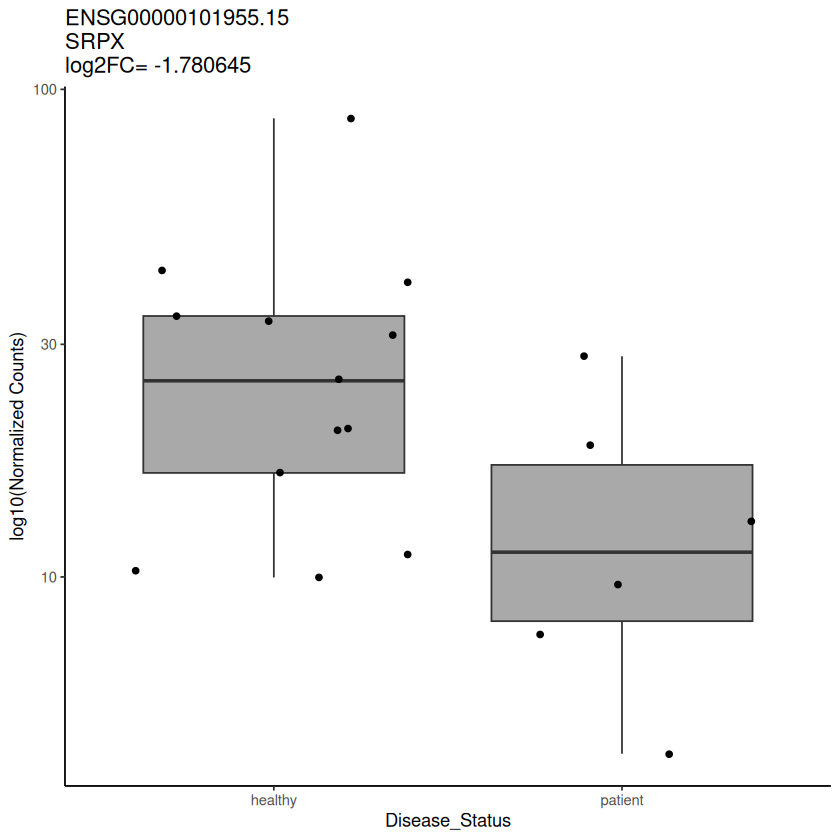

[1] "gene - no_individual_no_differentiation_cohort_Mature_organoids_male_comparison_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 25847 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3, 0.012%
LFC < 0 (down)     : 1, 0.0039%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 25847 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3, 0.012%
LFC < 0 (down)     : 1, 0.0039%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 25847 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1276, 4.9%
LFC < 0 (down)     : 513, 2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


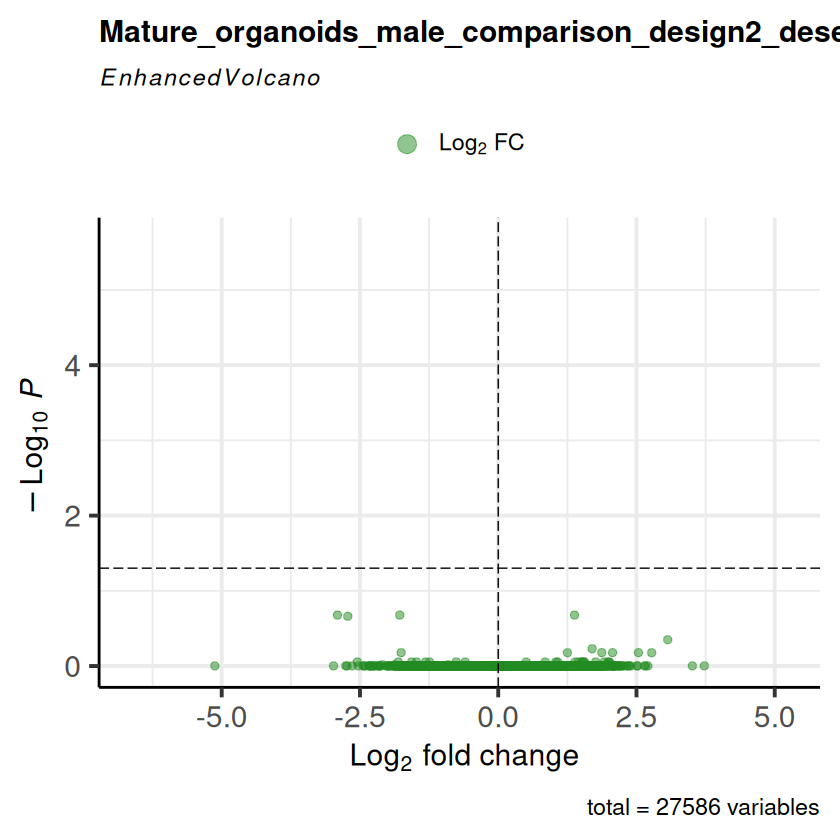

Saving 7 x 7 in image


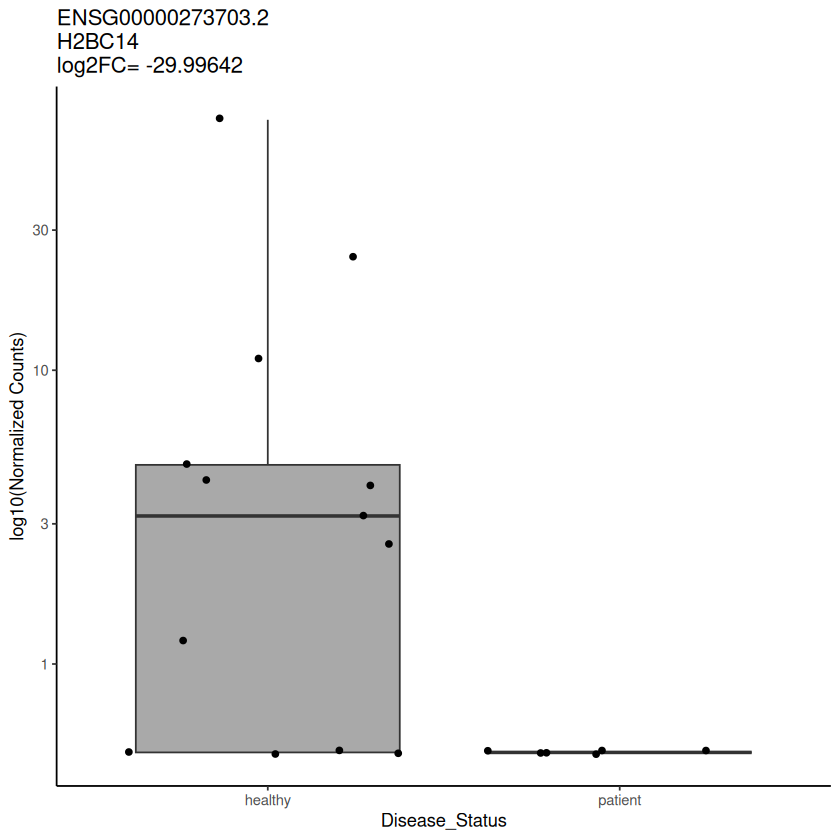

[1] "gene - Big_Model_All_Sample_nodeltaSVA_Comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



29 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 29362 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 34, 0.12%
LFC < 0 (down)     : 41, 0.14%
outliers [1]       : 0, 0%
low counts [2]     : 4554, 16%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 29362 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 41, 0.14%
LFC < 0 (down)     : 62, 0.21%
outliers [1]       : 0, 0%
low counts [2]     : 11955, 41%
(mean count < 15)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 29362 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1229, 4.2%
LFC < 0 (down)     : 1479, 5%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


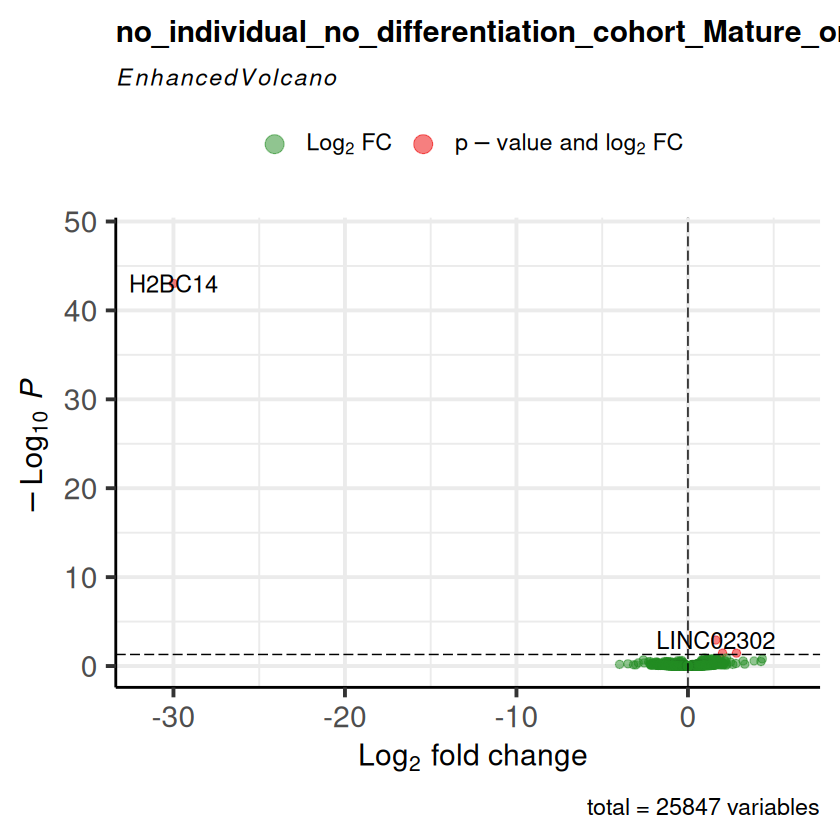

Saving 7 x 7 in image


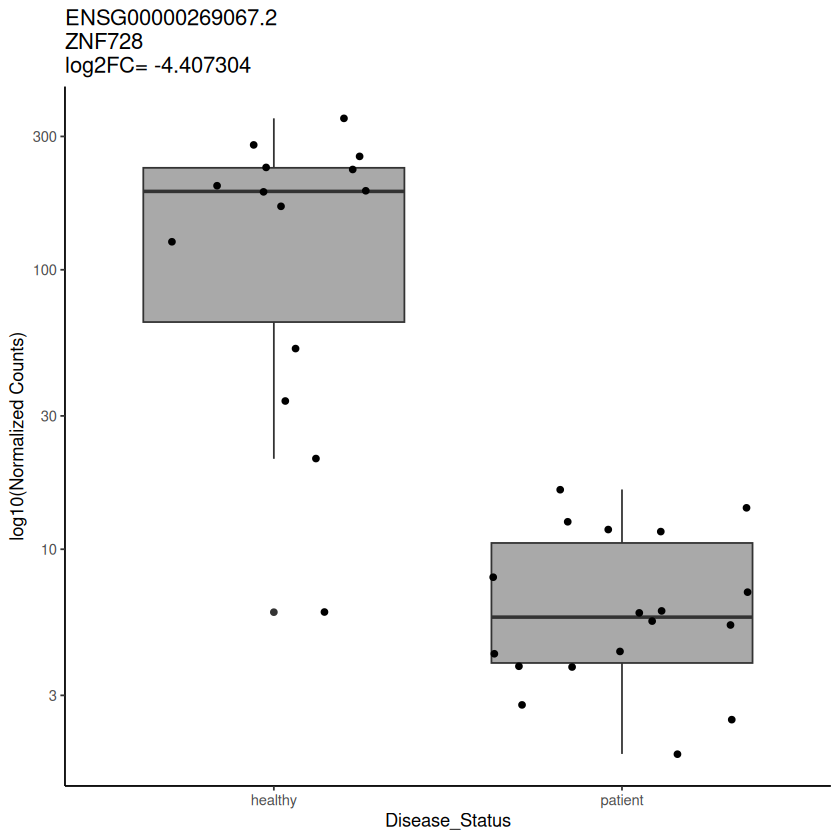

[1] "gene - Big_Model_All_Sample_nodeltaSVA_Comparison_design2_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



10 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 27655 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 15, 0.054%
LFC < 0 (down)     : 15, 0.054%
outliers [1]       : 0, 0%
low counts [2]     : 537, 1.9%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 27655 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 22, 0.08%
LFC < 0 (down)     : 28, 0.1%
outliers [1]       : 0, 0%
low counts [2]     : 5362, 19%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 27655 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 805, 2.9%
LFC < 0 (down)     : 1443, 5.2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


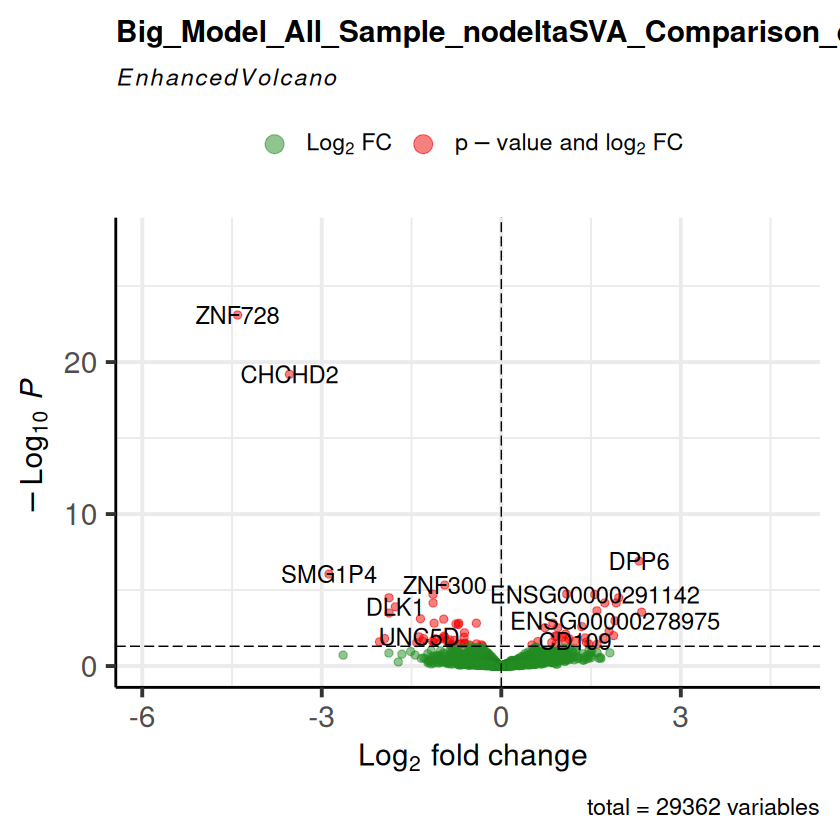

Saving 7 x 7 in image


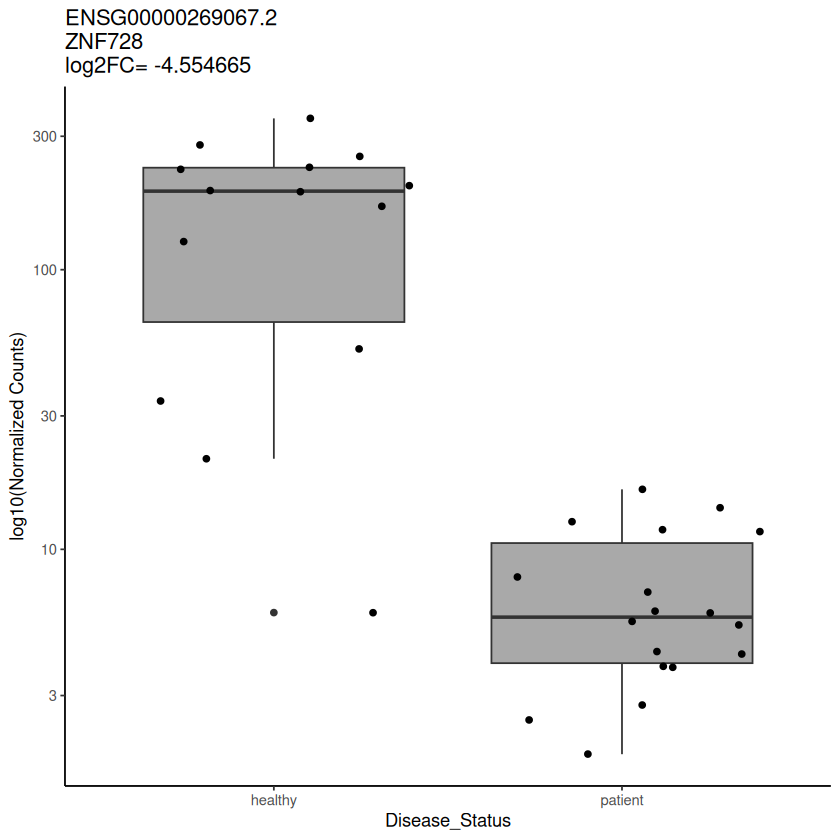

[1] "gene - Mature_organoids_male__nodeltaSVA_comparison_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 26290 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 41, 0.16%
LFC < 0 (down)     : 110, 0.42%
outliers [1]       : 0, 0%
low counts [2]     : 8155, 31%
(mean count < 13)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26290 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 106, 0.4%
LFC < 0 (down)     : 279, 1.1%
outliers [1]       : 0, 0%
low counts [2]     : 8155, 31%
(mean count < 13)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26290 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1402, 5.3%
LFC < 0 (down)     : 2201, 8.4%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


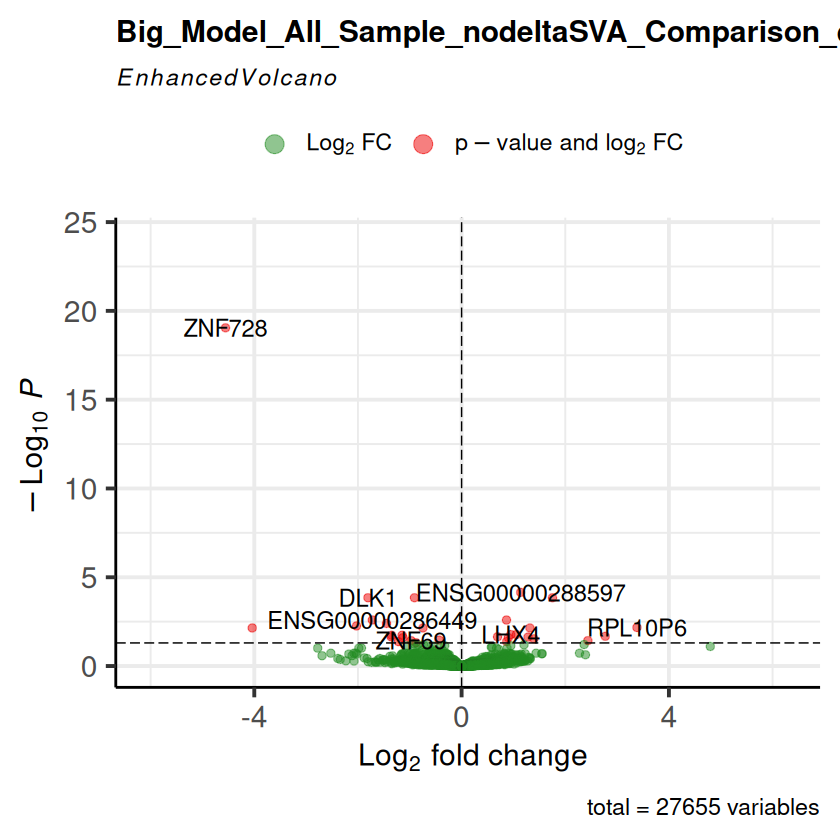

Saving 7 x 7 in image


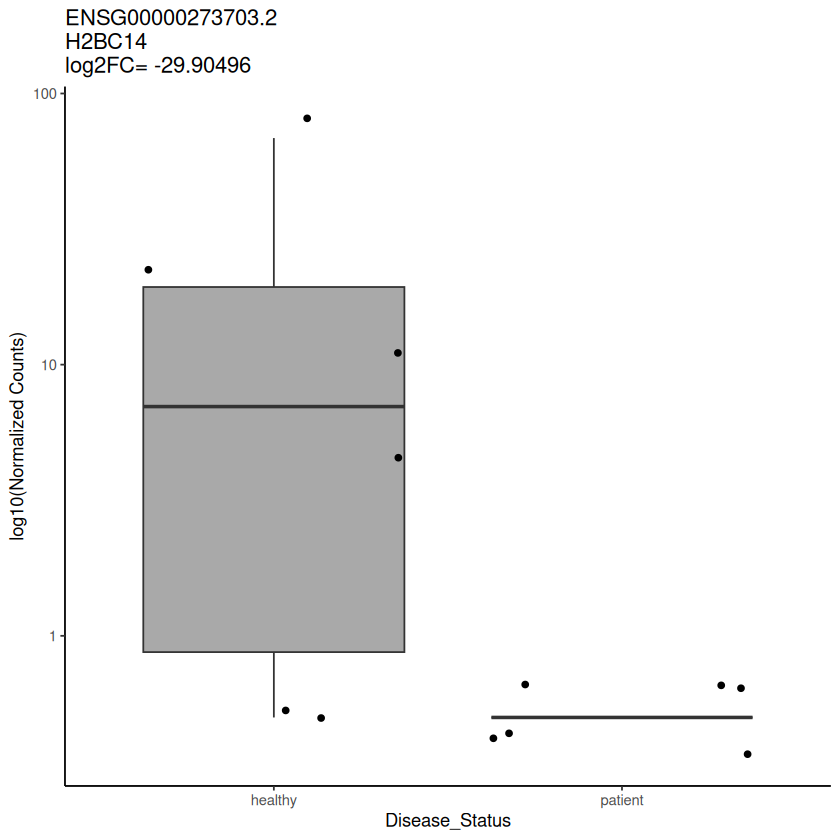

[1] "gene - Mature_organoids_male_no_individual_no_differentiation_cohort_nodeltaSVA_comparison_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 26290 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 14, 0.053%
LFC < 0 (down)     : 2, 0.0076%
outliers [1]       : 0, 0%
low counts [2]     : 4588, 17%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26290 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 16, 0.061%
LFC < 0 (down)     : 6, 0.023%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26290 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1357, 5.2%
LFC < 0 (down)     : 1107, 4.2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


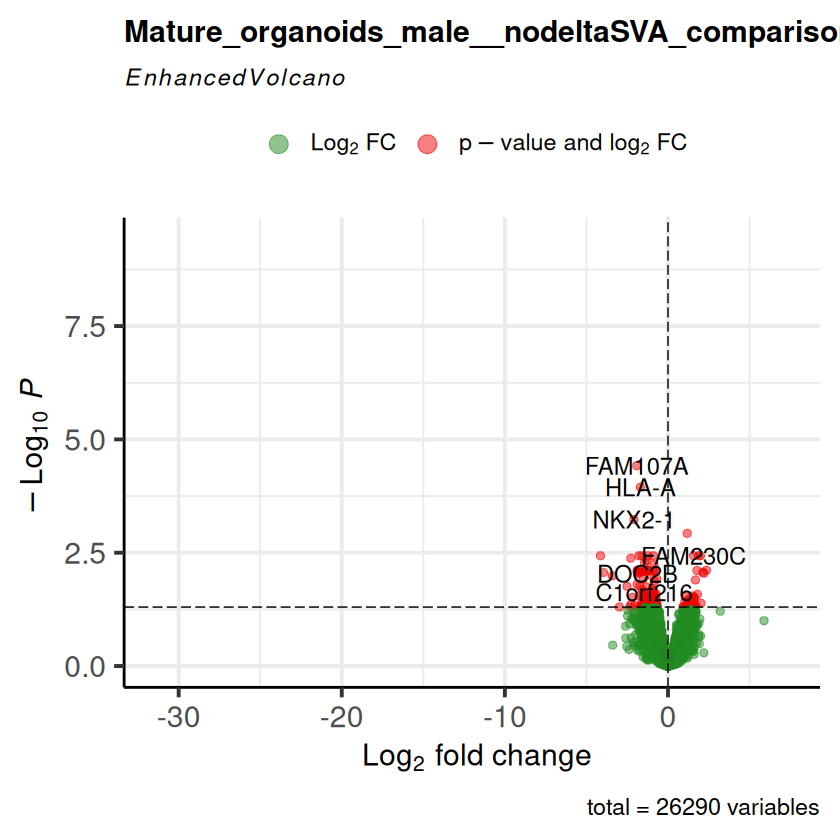

Saving 7 x 7 in image


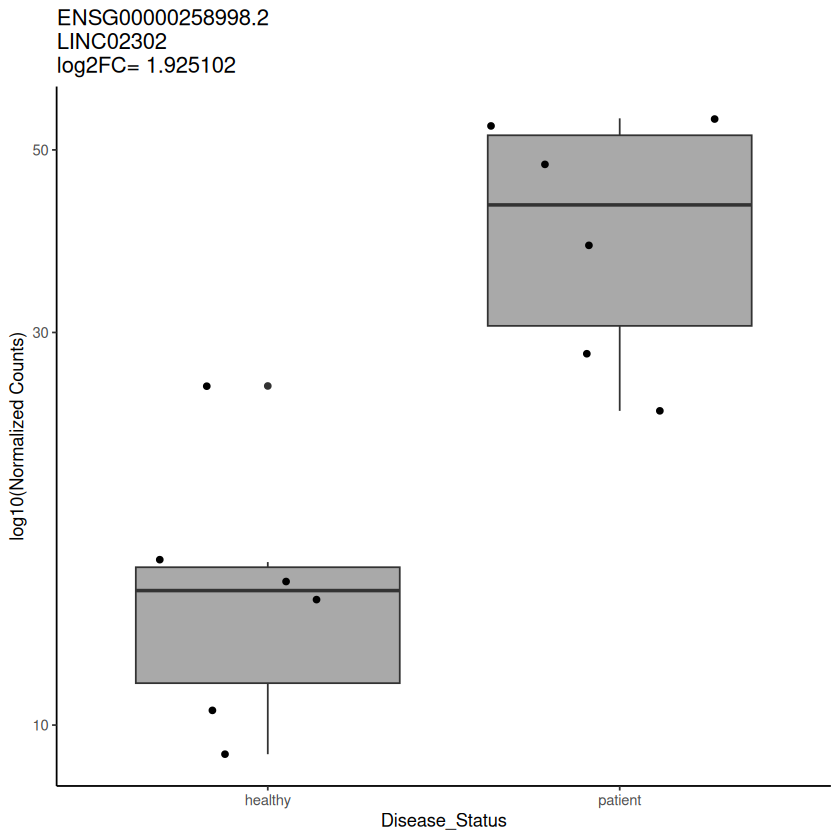

[1] "gene - Mature_organoids_DELTASVA_comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



8 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 27182 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 27182 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 27182 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 410, 1.5%
LFC < 0 (down)     : 378, 1.4%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


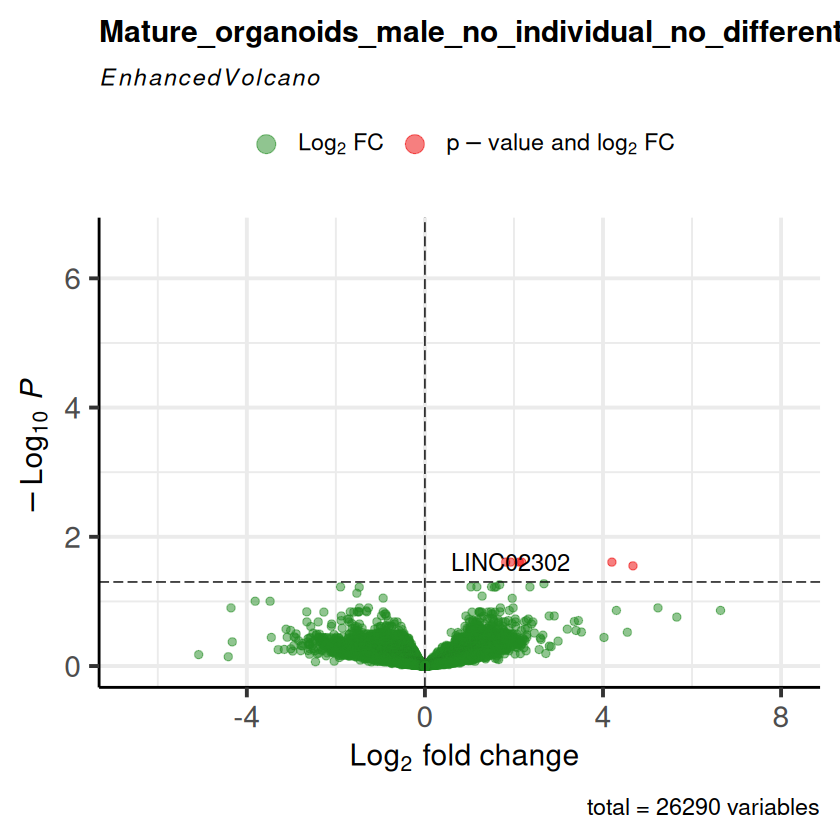

Saving 7 x 7 in image


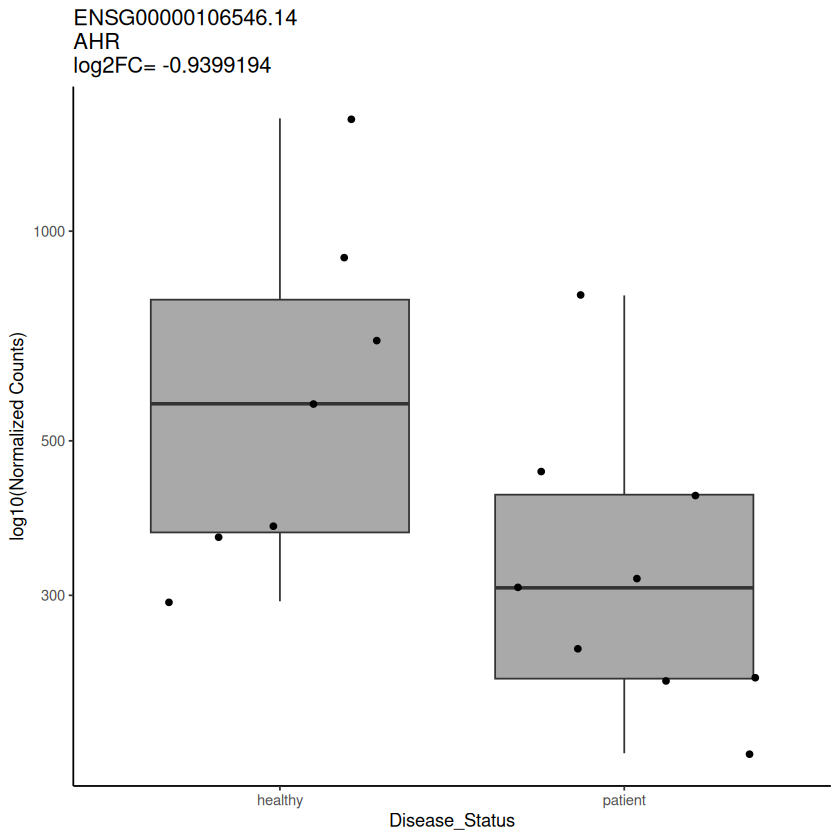

[1] "gene - Mature_organoids_DELTASVA_comparison_design2_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 27182 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 27182 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 27182 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 441, 1.6%
LFC < 0 (down)     : 311, 1.1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


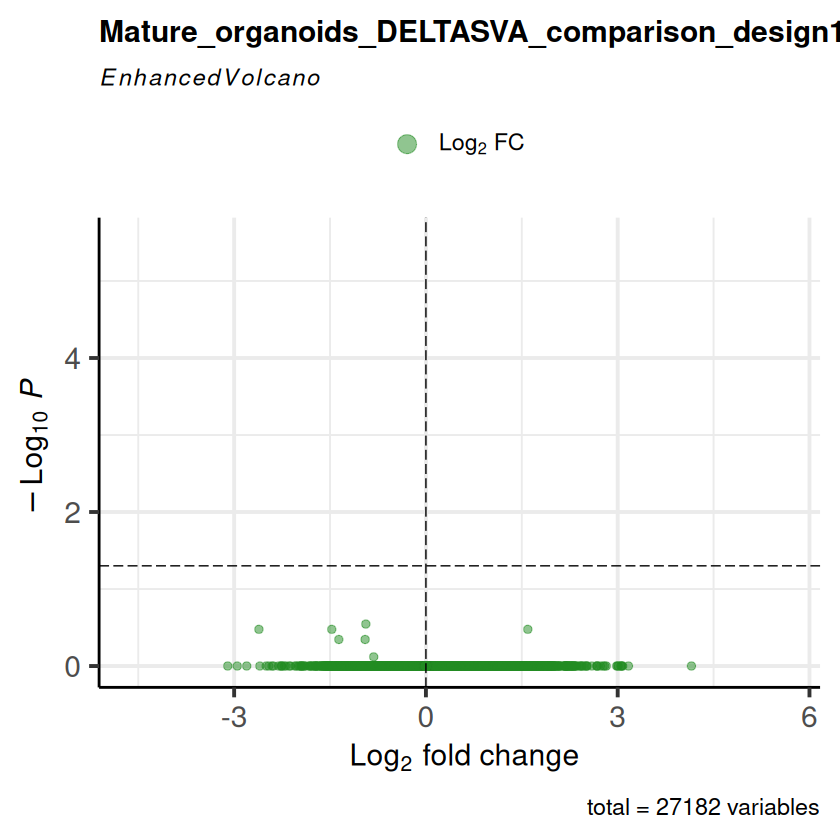

Saving 7 x 7 in image


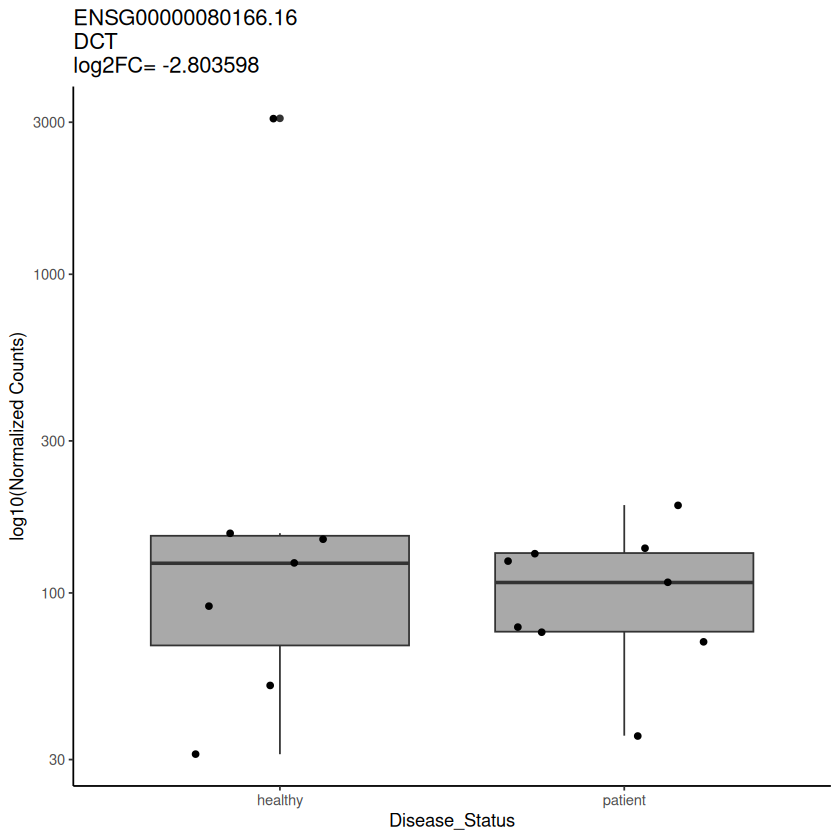

[1] "gene - Mature_organoids_DELTASVA_male_comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



1 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26017 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 544, 2.1%
LFC < 0 (down)     : 344, 1.3%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


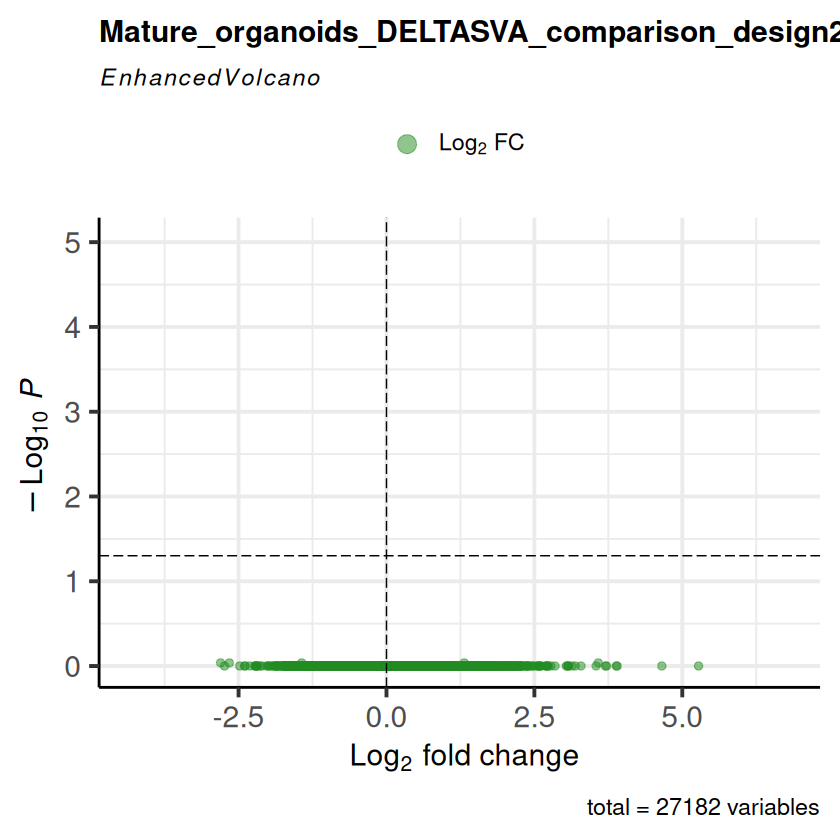

Saving 7 x 7 in image


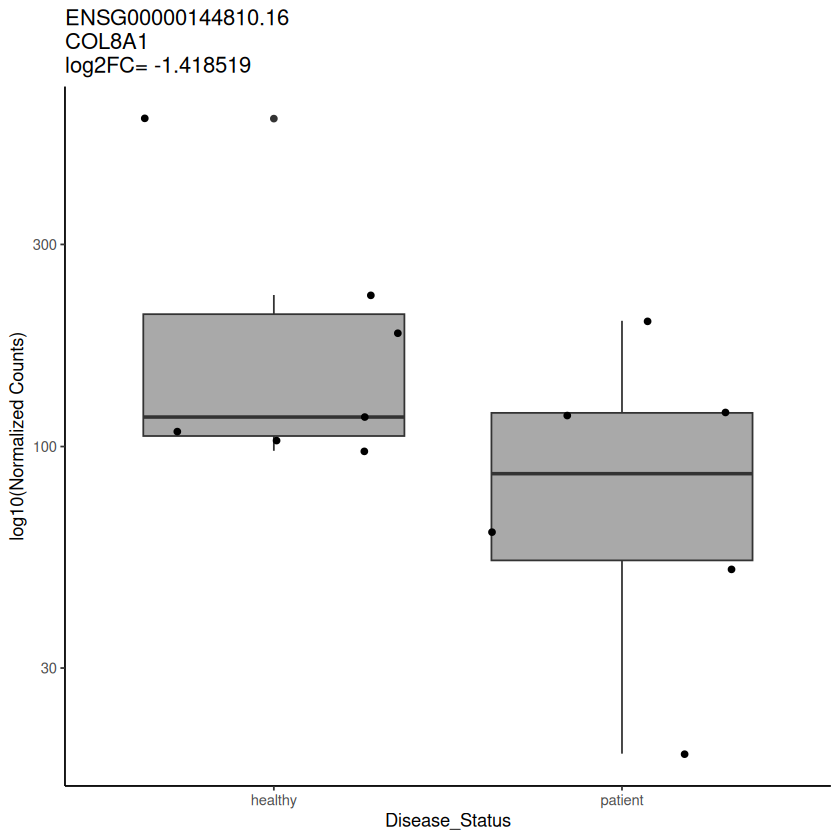

[1] "gene - Mature_organoids_DELTASVA_male_comparison_design2_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26017 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 552, 2.1%
LFC < 0 (down)     : 222, 0.85%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


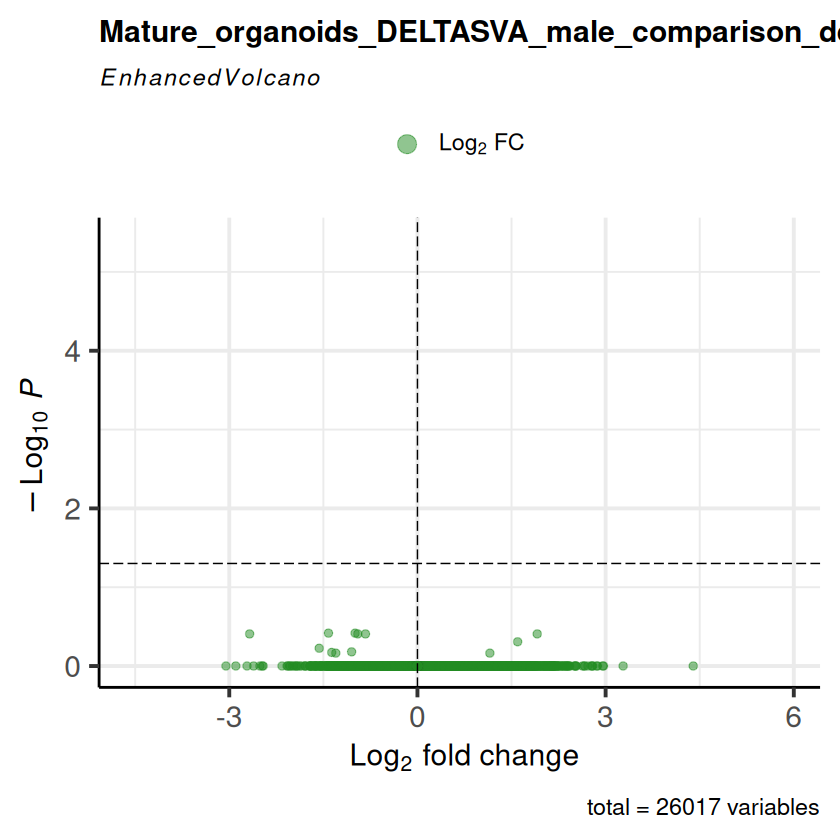

Saving 7 x 7 in image


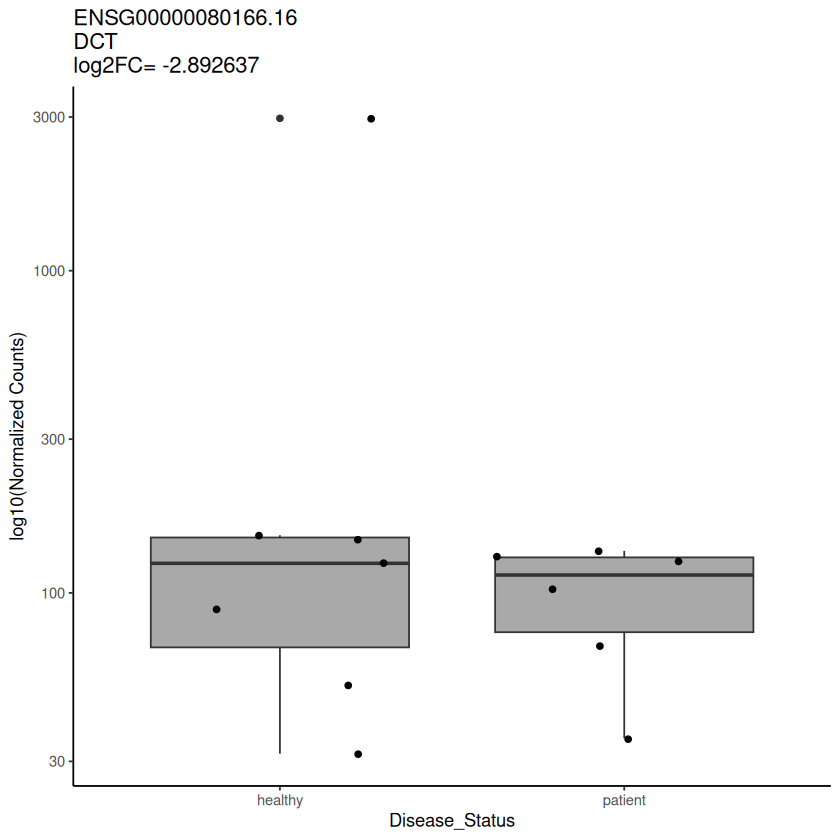

[1] "gene - no_individual_no_differentiation_cohort_DELTASVA_Mature_organoids_male_comparison_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26017 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 618, 2.4%
LFC < 0 (down)     : 265, 1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


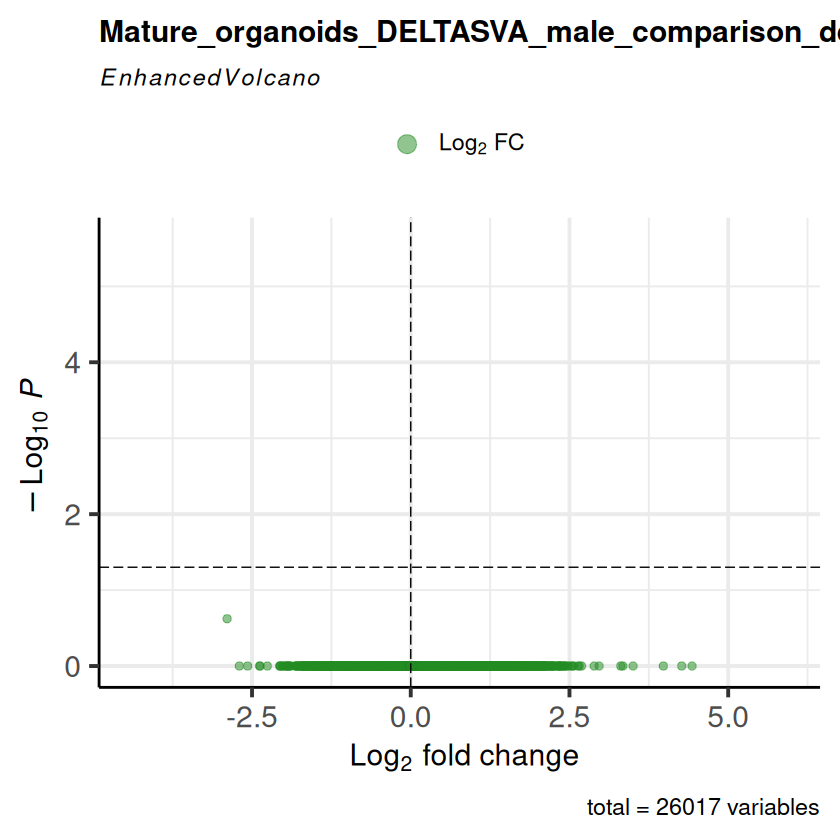

Saving 7 x 7 in image


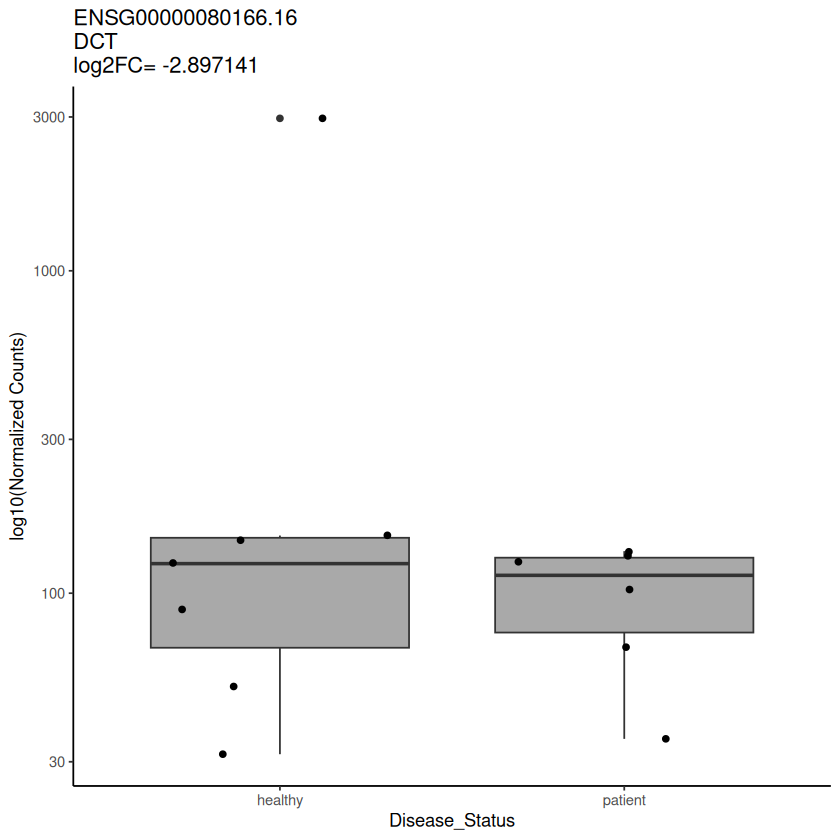

[1] "gene - Big_Model_All_Sample_DELTASVA_Comparison_design1_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



1 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 27770 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 267, 0.96%
LFC < 0 (down)     : 197, 0.71%
outliers [1]       : 0, 0%
low counts [2]     : 9153, 33%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 27770 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 474, 1.7%
LFC < 0 (down)     : 449, 1.6%
outliers [1]       : 0, 0%
low counts [2]     : 9153, 33%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 27770 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2047, 7.4%
LFC < 0 (down)     : 2422, 8.7%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


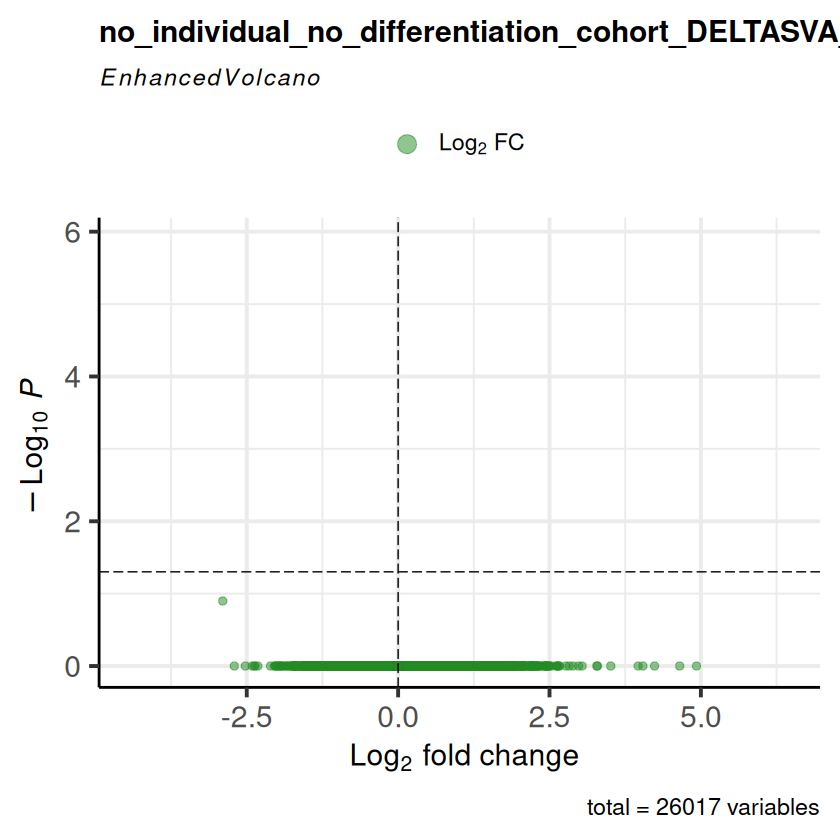

Saving 7 x 7 in image


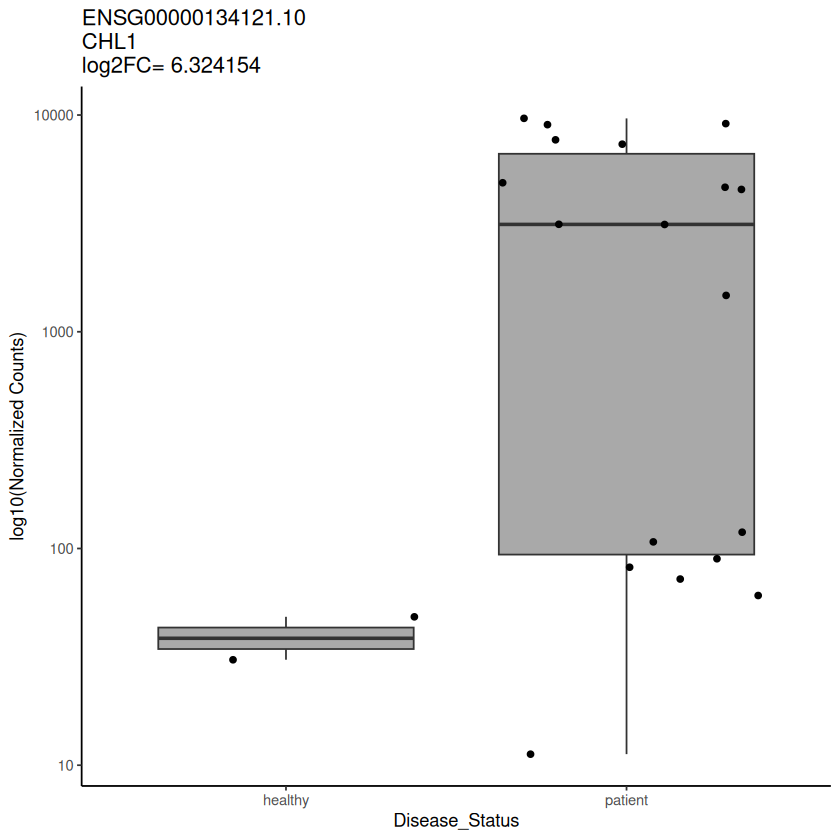

[1] "gene - Big_Model_All_Sample_DELTASVA_Comparison_design2_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



5 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 27770 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 163, 0.59%
LFC < 0 (down)     : 128, 0.46%
outliers [1]       : 0, 0%
low counts [2]     : 8076, 29%
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 27770 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 363, 1.3%
LFC < 0 (down)     : 349, 1.3%
outliers [1]       : 0, 0%
low counts [2]     : 8615, 31%
(mean count < 11)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 27770 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2204, 7.9%
LFC < 0 (down)     : 2496, 9%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


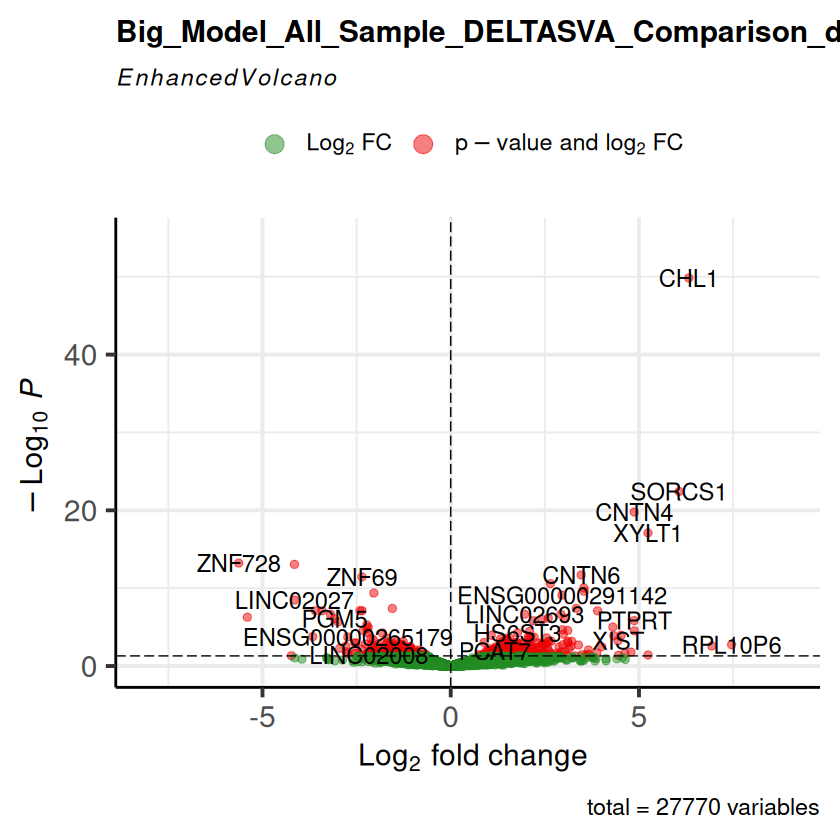

Saving 7 x 7 in image


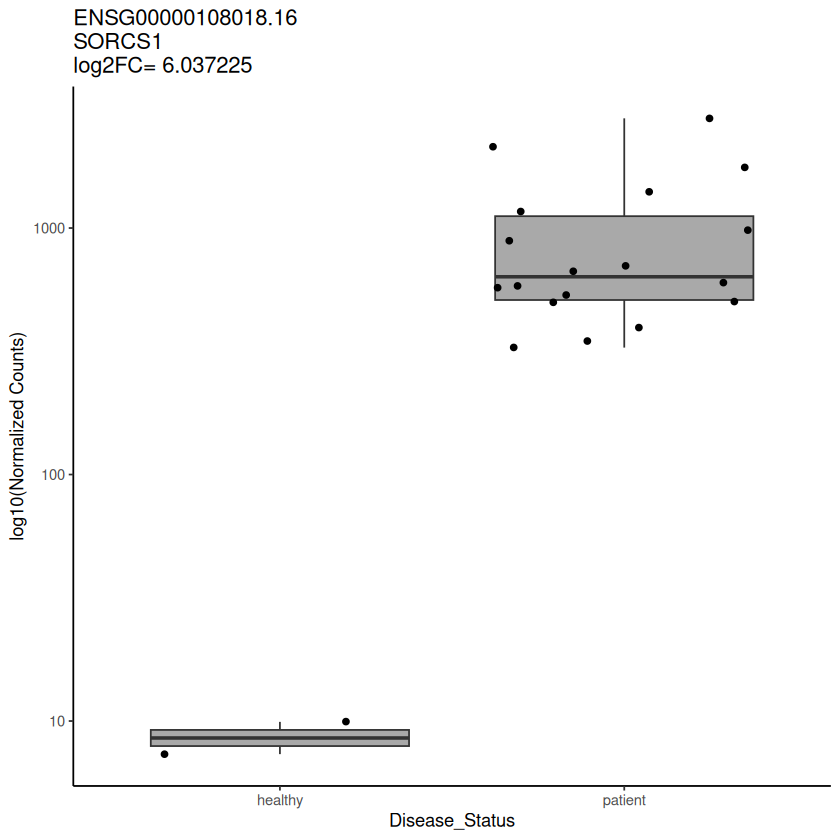

[1] "gene - Mature_organoids_male__DELTASVA_comparison_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing



1 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26017 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 544, 2.1%
LFC < 0 (down)     : 344, 1.3%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


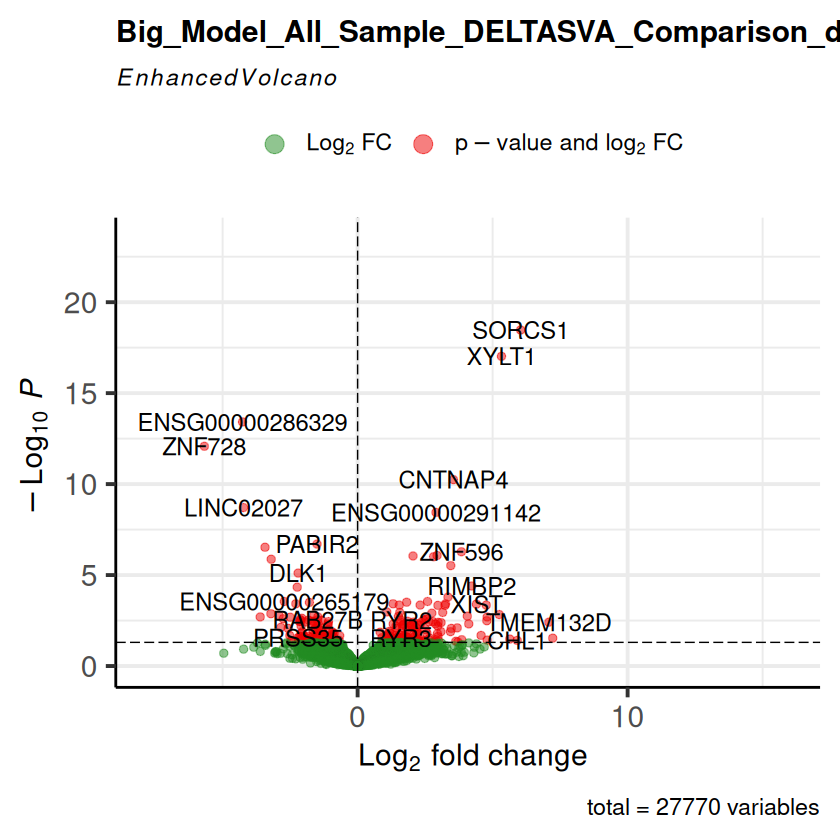

Saving 7 x 7 in image


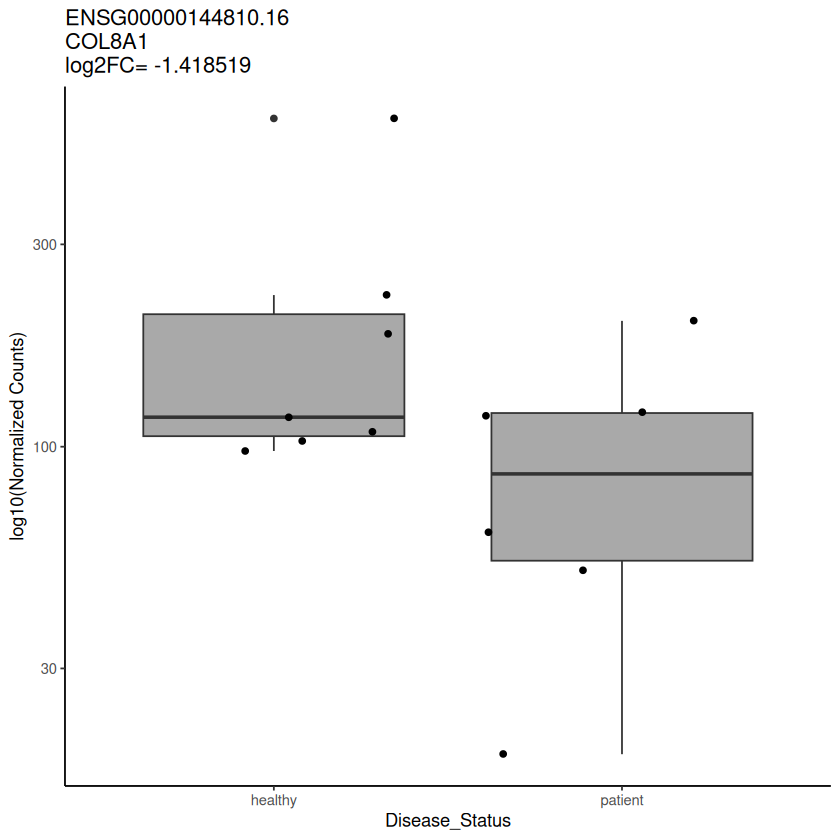

[1] "gene - Mature_organoids_male_no_individual_no_differentiation_cohort_DELTASVA_comparison_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26017 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26017 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 618, 2.4%
LFC < 0 (down)     : 265, 1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


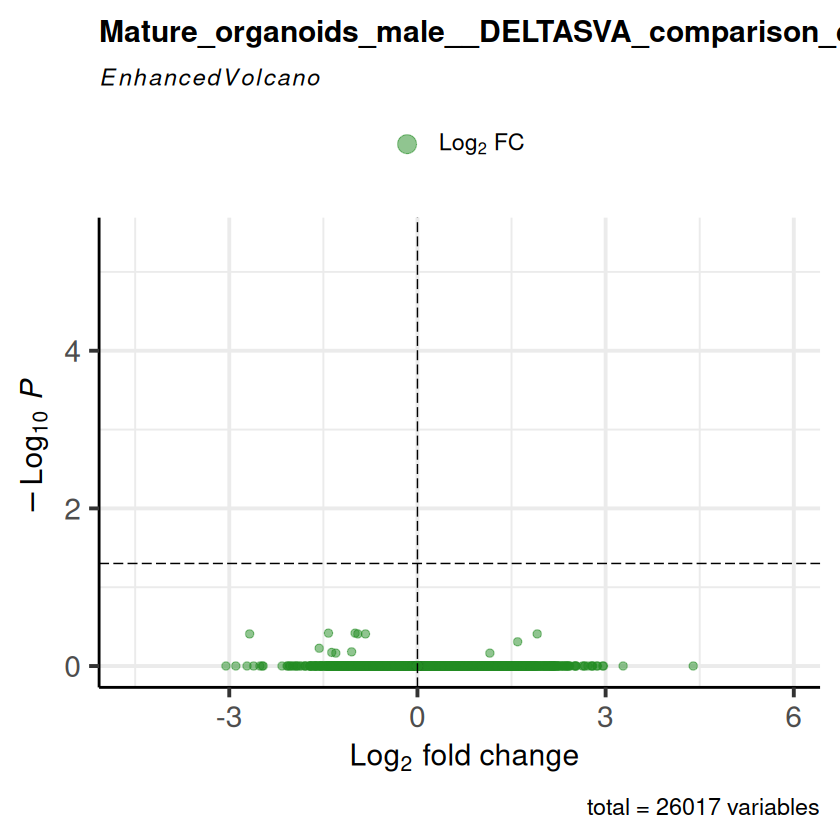

Saving 7 x 7 in image


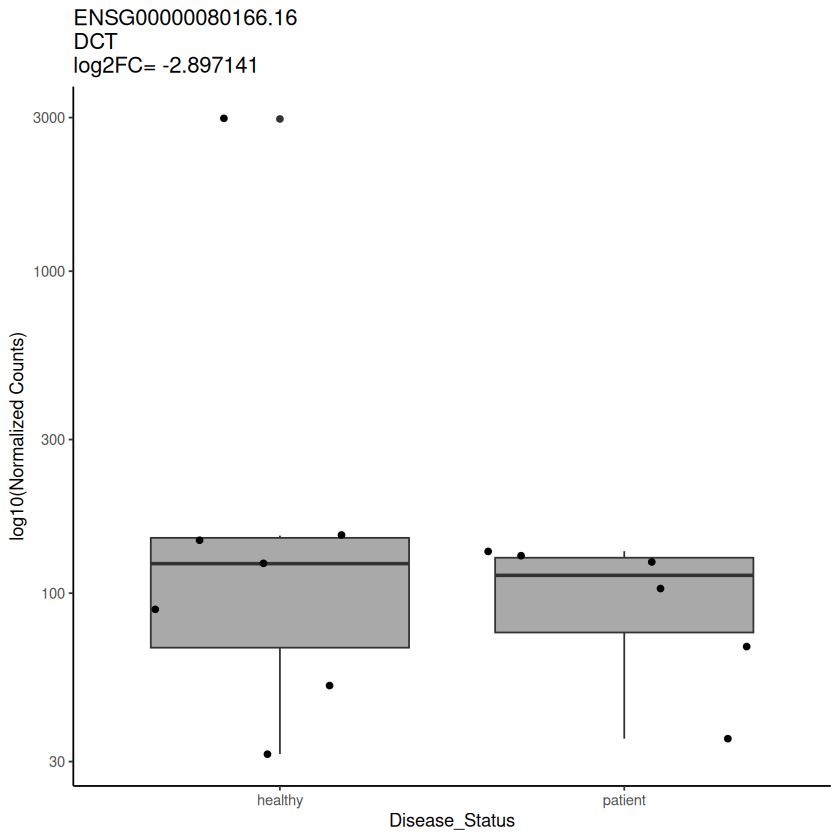

[1] "gene - Day30_All_Male_Pairwise_controlxdp_deseq2"


factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 22120 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5, 0.023%
LFC < 0 (down)     : 17, 0.077%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 22120 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 9, 0.041%
LFC < 0 (down)     : 18, 0.081%
outliers [1]       : 0, 0%
low counts [2]     : 7720, 35%
(mean count < 28)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 22120 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 104, 0.47%
LFC < 0 (down)     : 167, 0.75%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


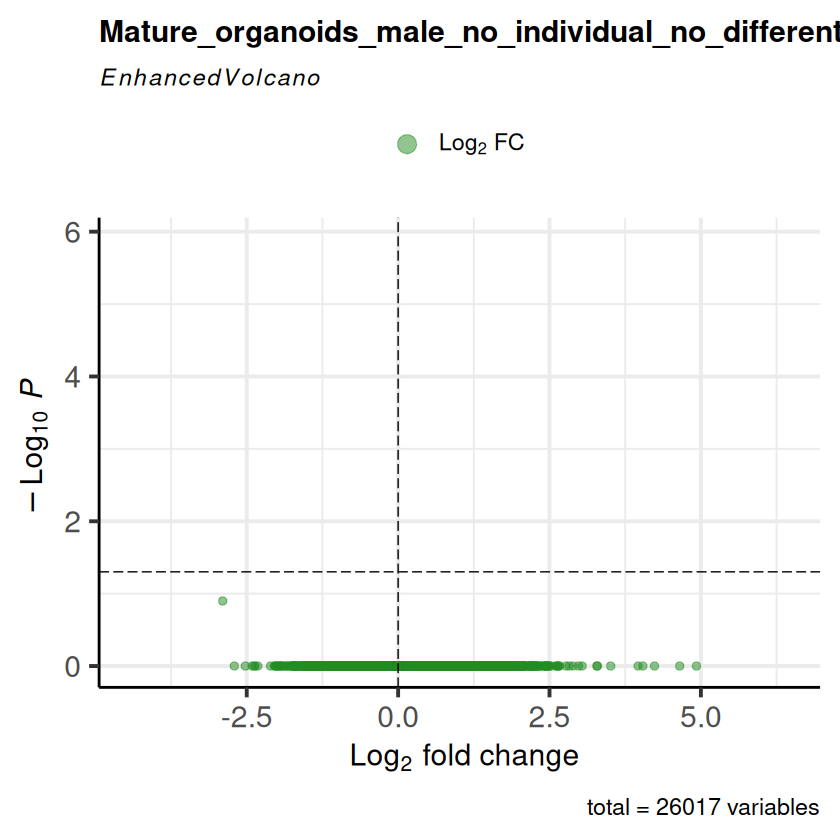

Saving 7 x 7 in image


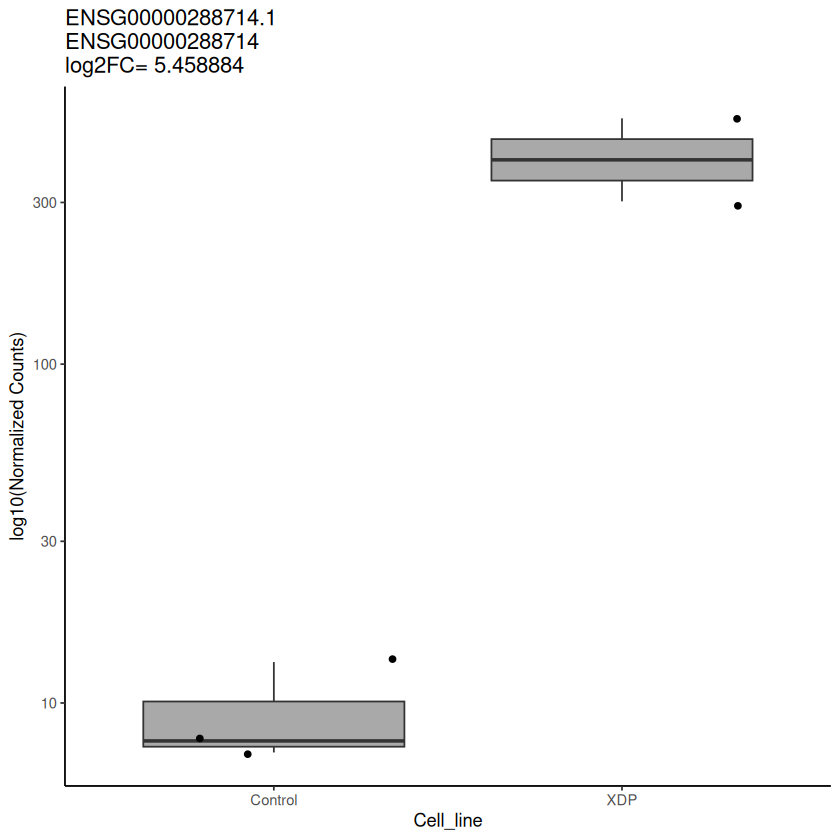

[1] "gene - Day30_All_Male_Pairwise_controldelta_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 23656 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 7, 0.03%
LFC < 0 (down)     : 2, 0.0085%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 23656 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 35, 0.15%
LFC < 0 (down)     : 14, 0.059%
outliers [1]       : 0, 0%
low counts [2]     : 6421, 27%
(mean count < 17)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 23656 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 932, 3.9%
LFC < 0 (down)     : 441, 1.9%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


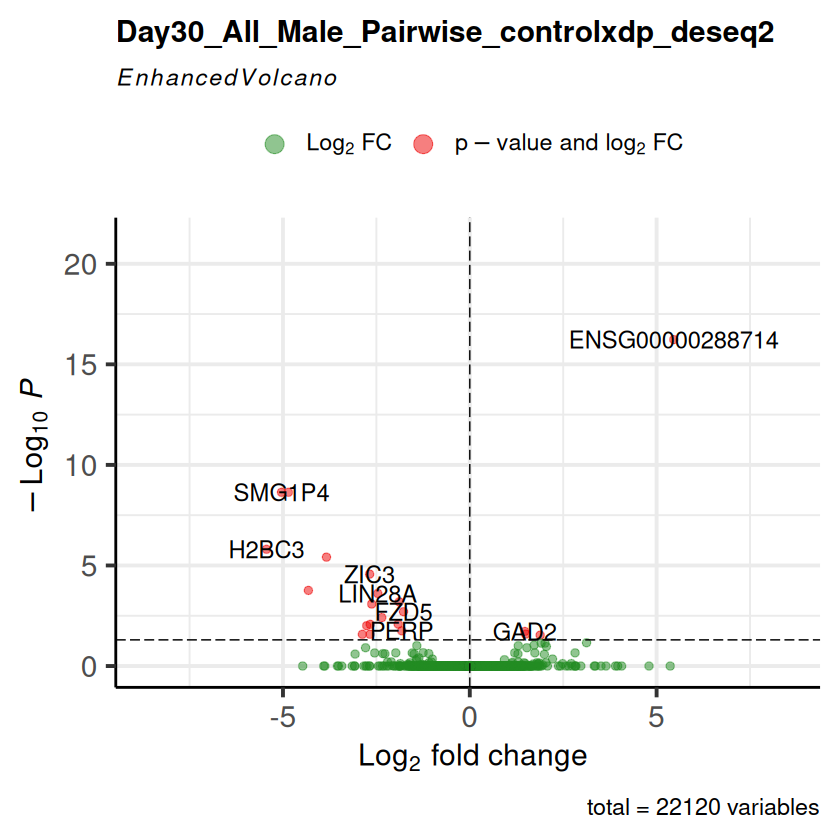

Saving 7 x 7 in image


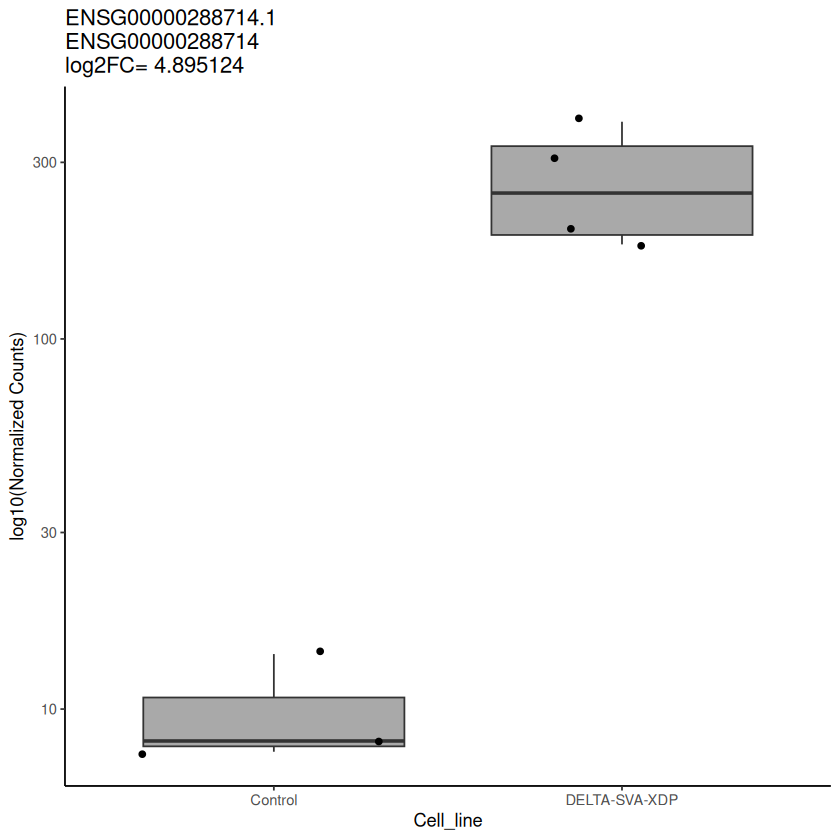

[1] "gene - Day30_All_Male_Pairwise_deltaxdp_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 26682 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 39, 0.15%
LFC < 0 (down)     : 118, 0.44%
outliers [1]       : 0, 0%
low counts [2]     : 9829, 37%
(mean count < 19)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 26682 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 91, 0.34%
LFC < 0 (down)     : 225, 0.84%
outliers [1]       : 0, 0%
low counts [2]     : 10346, 39%
(mean count < 21)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 26682 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 765, 2.9%
LFC < 0 (down)     : 1834, 6.9%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


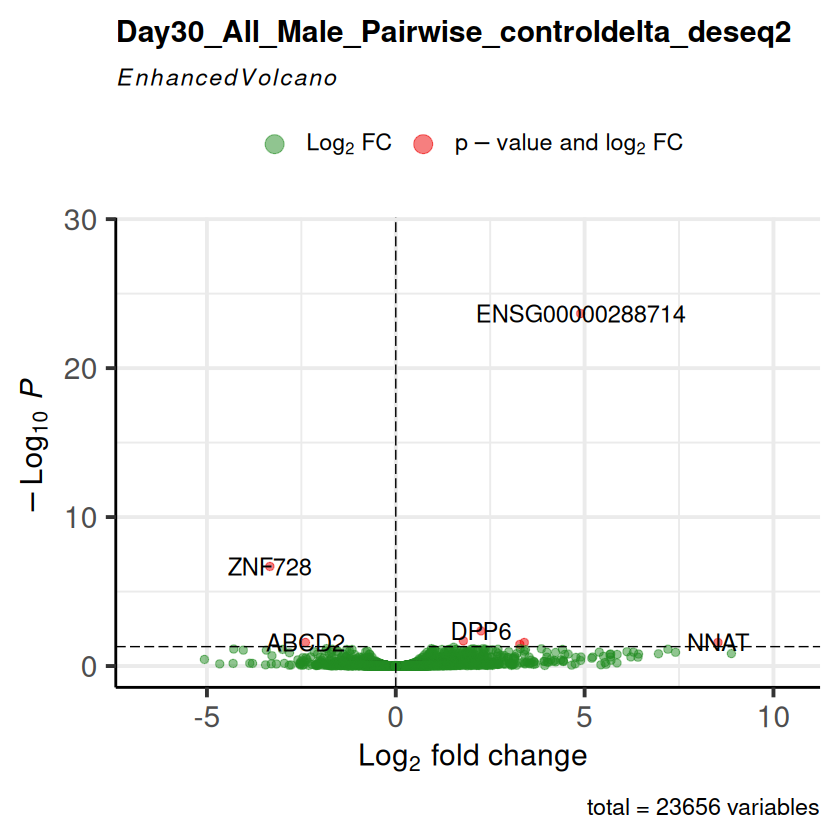

Saving 7 x 7 in image


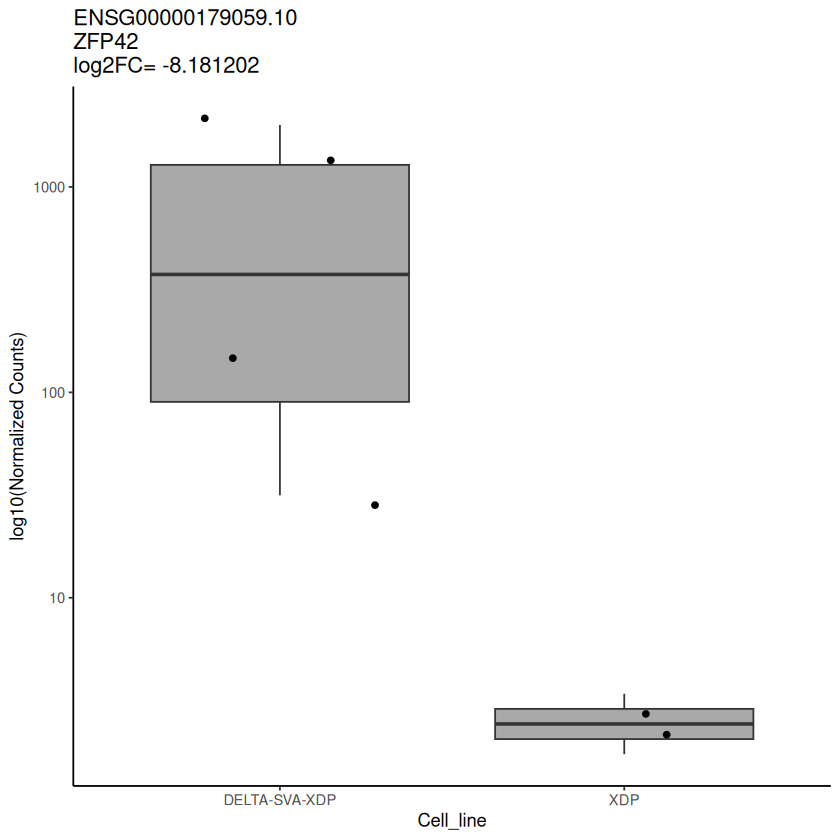

[1] "gene - Day60_All_Male_Pairwise_controlxdp_deseq2"


factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 23135 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 18, 0.078%
LFC < 0 (down)     : 51, 0.22%
outliers [1]       : 0, 0%
low counts [2]     : 9419, 41%
(mean count < 32)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 23135 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 27, 0.12%
LFC < 0 (down)     : 95, 0.41%
outliers [1]       : 0, 0%
low counts [2]     : 10765, 47%
(mean count < 46)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 23135 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 305, 1.3%
LFC < 0 (down)     : 496, 2.1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


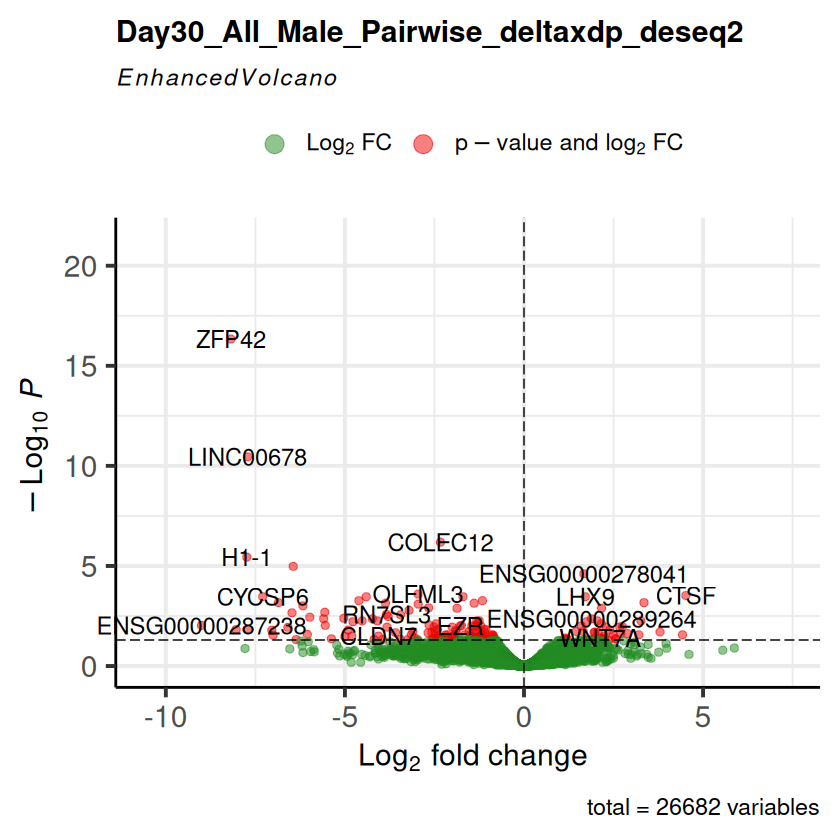

Saving 7 x 7 in image


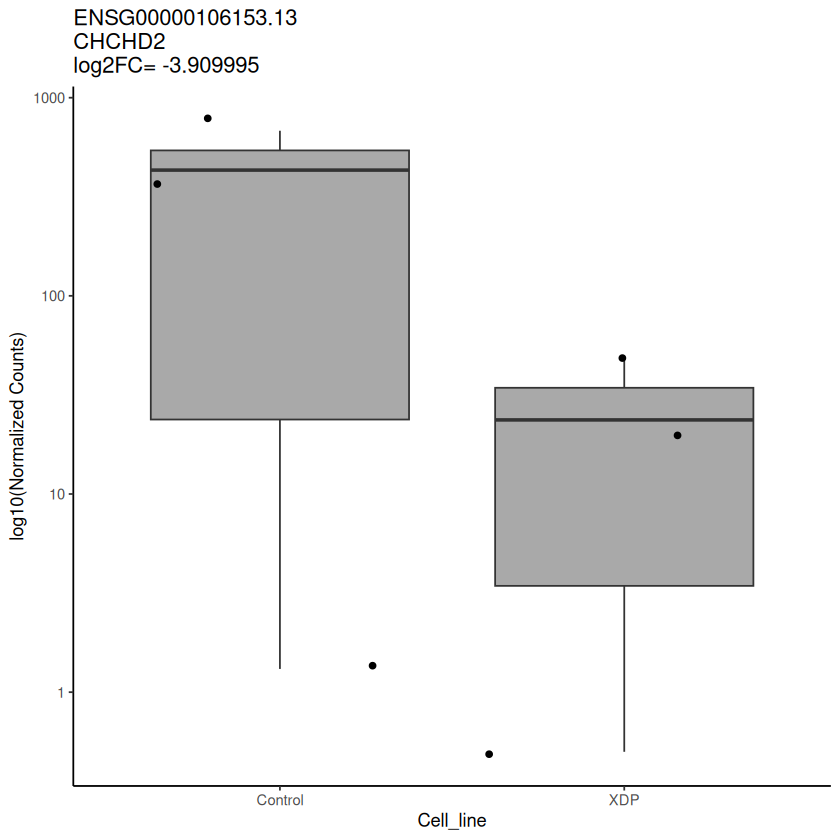

[1] "gene - Day60_All_Male_Pairwise_controldelta_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 25634 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 361, 1.4%
LFC < 0 (down)     : 455, 1.8%
outliers [1]       : 0, 0%
low counts [2]     : 5964, 23%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 25634 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 809, 3.2%
LFC < 0 (down)     : 803, 3.1%
outliers [1]       : 0, 0%
low counts [2]     : 3976, 16%
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 25634 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2904, 11%
LFC < 0 (down)     : 2395, 9.3%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


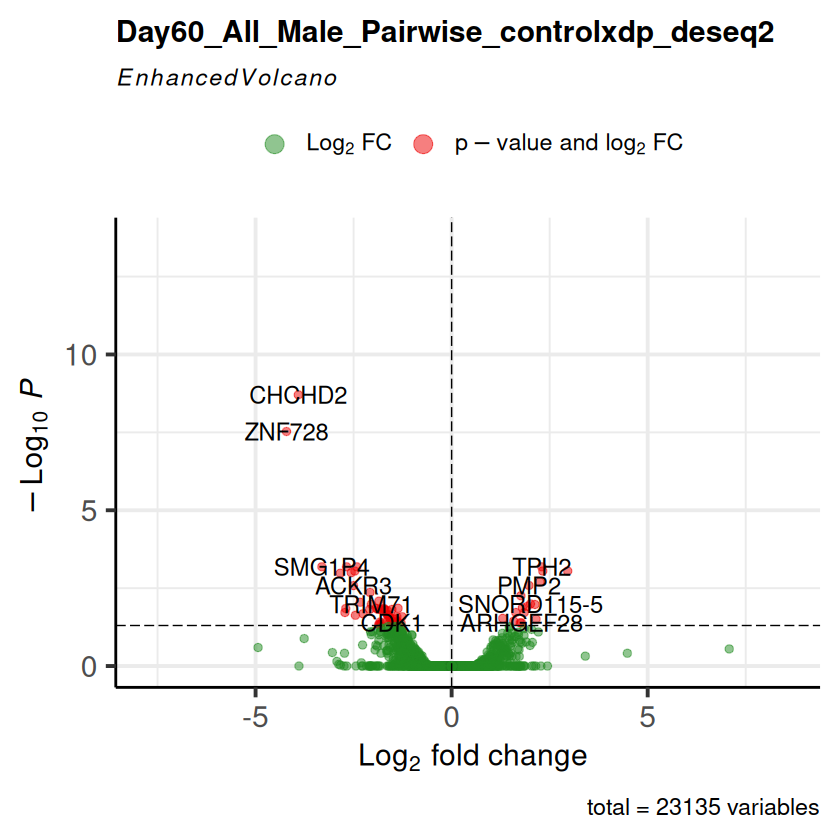

Saving 7 x 7 in image


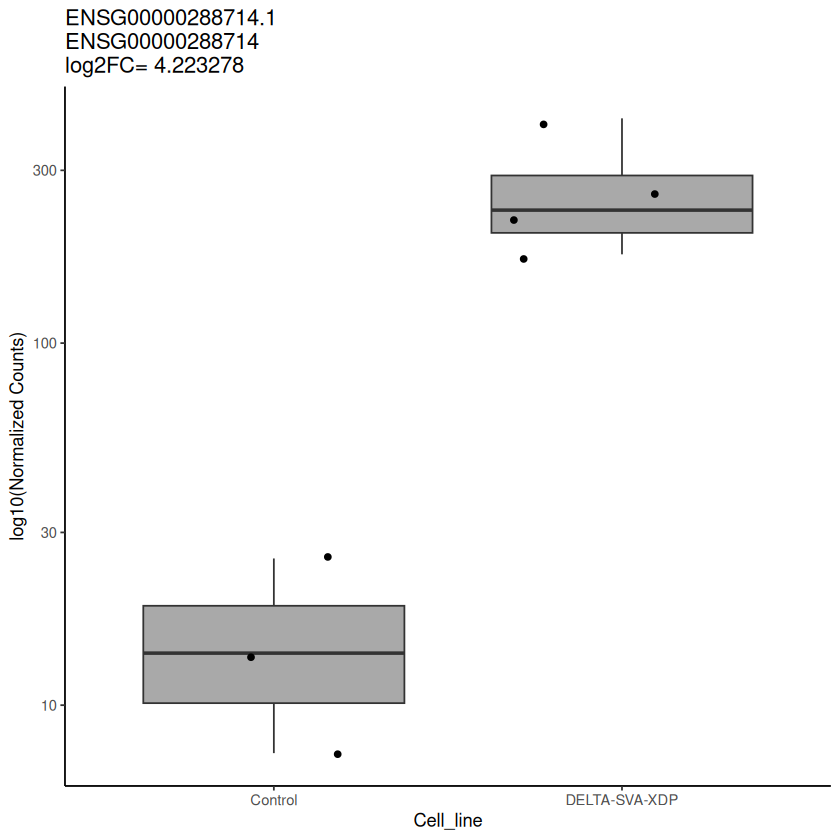

[1] "gene - Day60_All_Male_Pairwise_deltaxdp_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 28547 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5, 0.018%
LFC < 0 (down)     : 14, 0.049%
outliers [1]       : 0, 0%
low counts [2]     : 9409, 33%
(mean count < 12)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 28547 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 5, 0.018%
LFC < 0 (down)     : 16, 0.056%
outliers [1]       : 0, 0%
low counts [2]     : 11069, 39%
(mean count < 15)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 28547 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 246, 0.86%
LFC < 0 (down)     : 212, 0.74%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


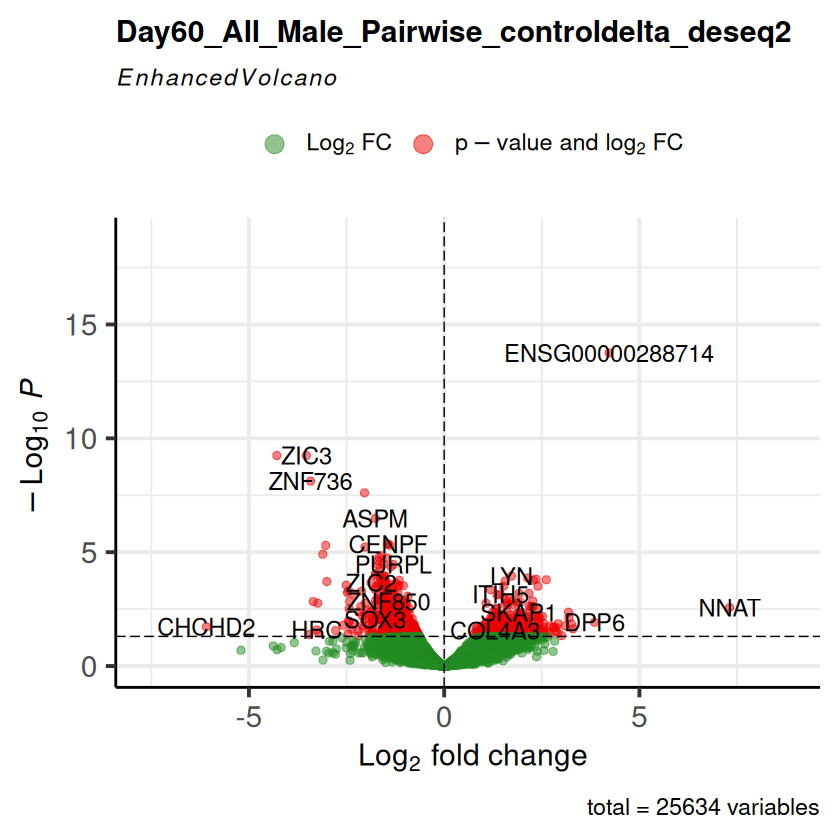

Saving 7 x 7 in image


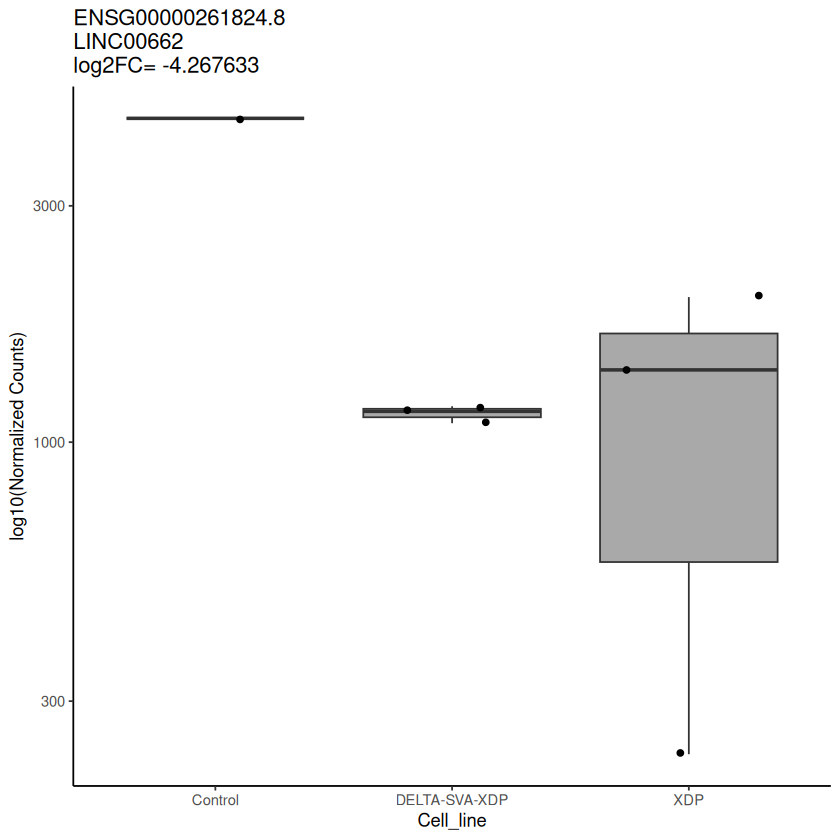

[1] "gene - Day90_All_Male_Pairwise_controlxdp_deseq2"


factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 23151 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.0043%
LFC < 0 (down)     : 5, 0.022%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 23151 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.0086%
LFC < 0 (down)     : 5, 0.022%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 23151 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 307, 1.3%
LFC < 0 (down)     : 838, 3.6%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


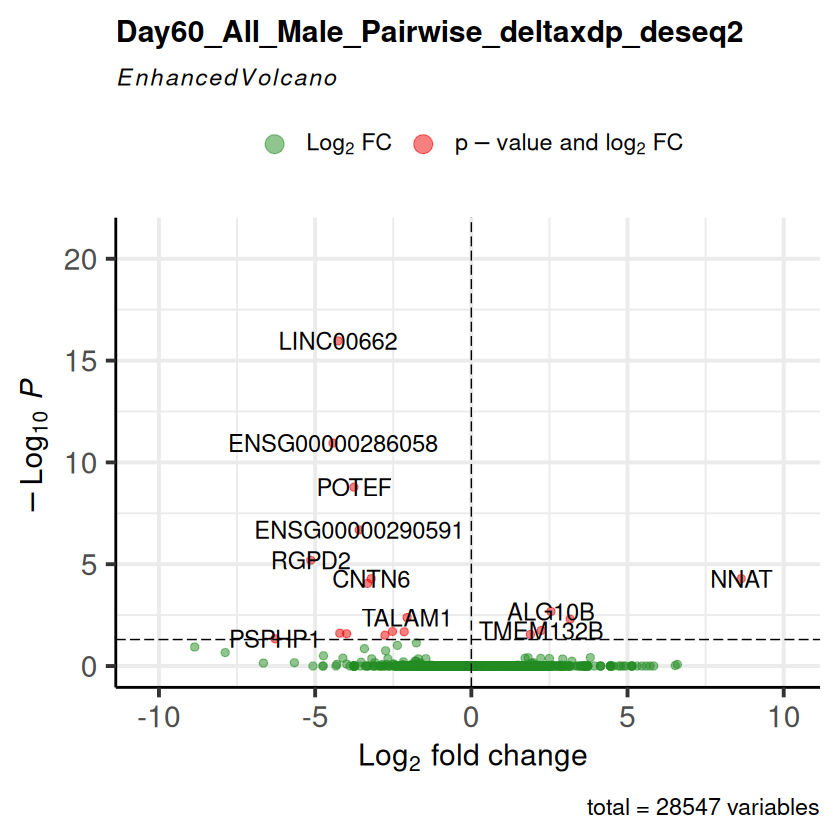

Saving 7 x 7 in image


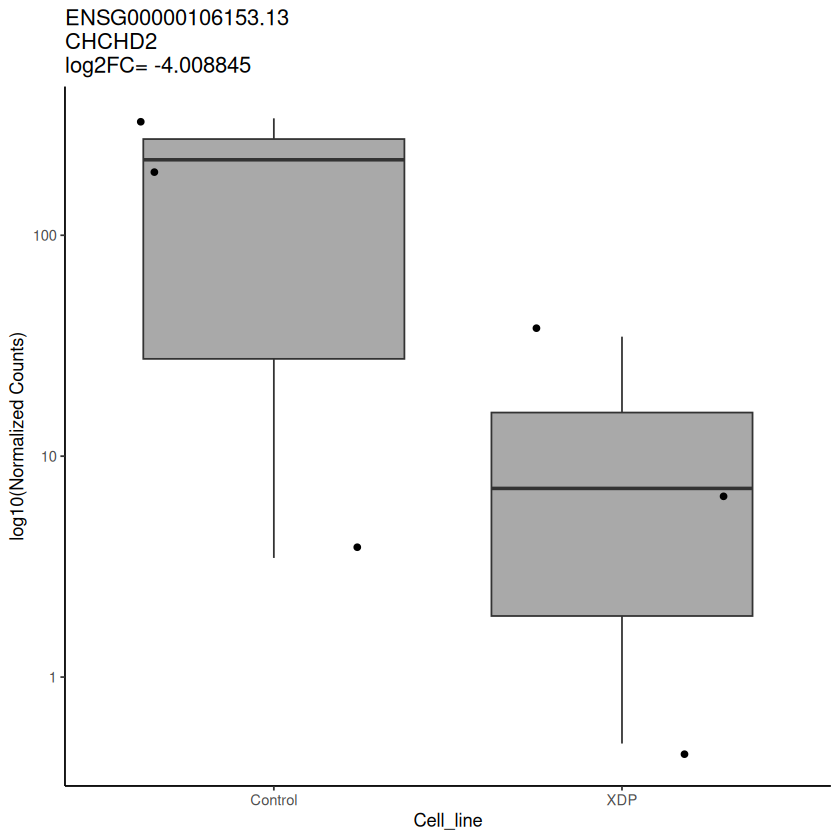

[1] "gene - Day90_All_Male_Pairwise_controldelta_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 23029 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 27, 0.12%
LFC < 0 (down)     : 390, 1.7%
outliers [1]       : 0, 0%
low counts [2]     : 6697, 29%
(mean count < 16)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 23029 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 48, 0.21%
LFC < 0 (down)     : 617, 2.7%
outliers [1]       : 0, 0%
low counts [2]     : 5804, 25%
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 23029 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 456, 2%
LFC < 0 (down)     : 2047, 8.9%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


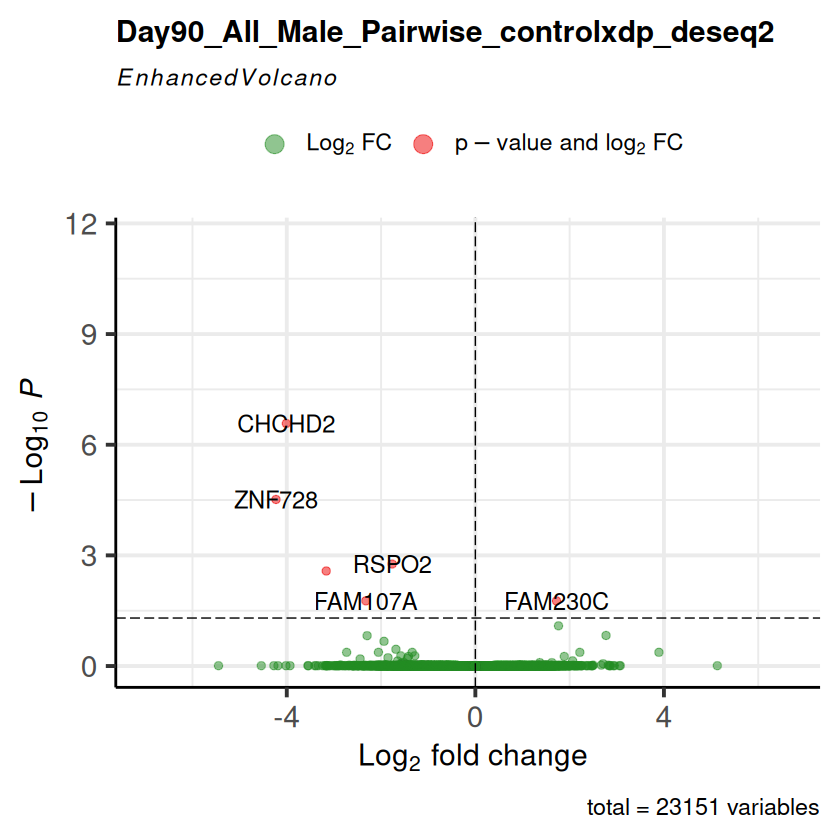

Saving 7 x 7 in image


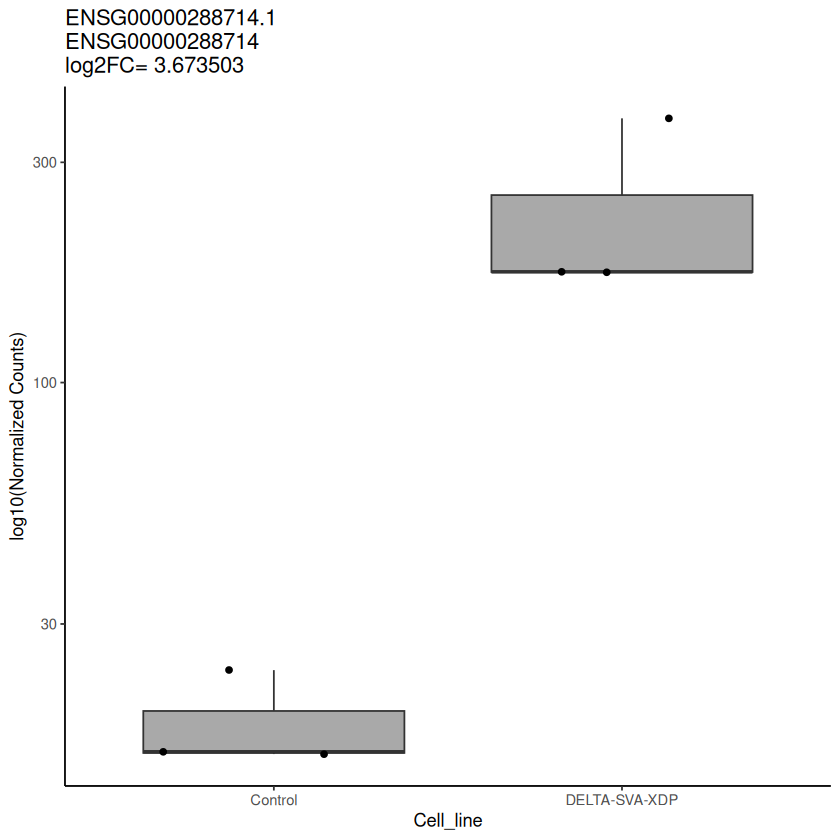

[1] "gene - Day90_All_Male_Pairwise_deltaxdp_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 21633 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 1, 0.0046%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 21633 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 1, 0.0046%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 21633 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 67, 0.31%
LFC < 0 (down)     : 93, 0.43%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


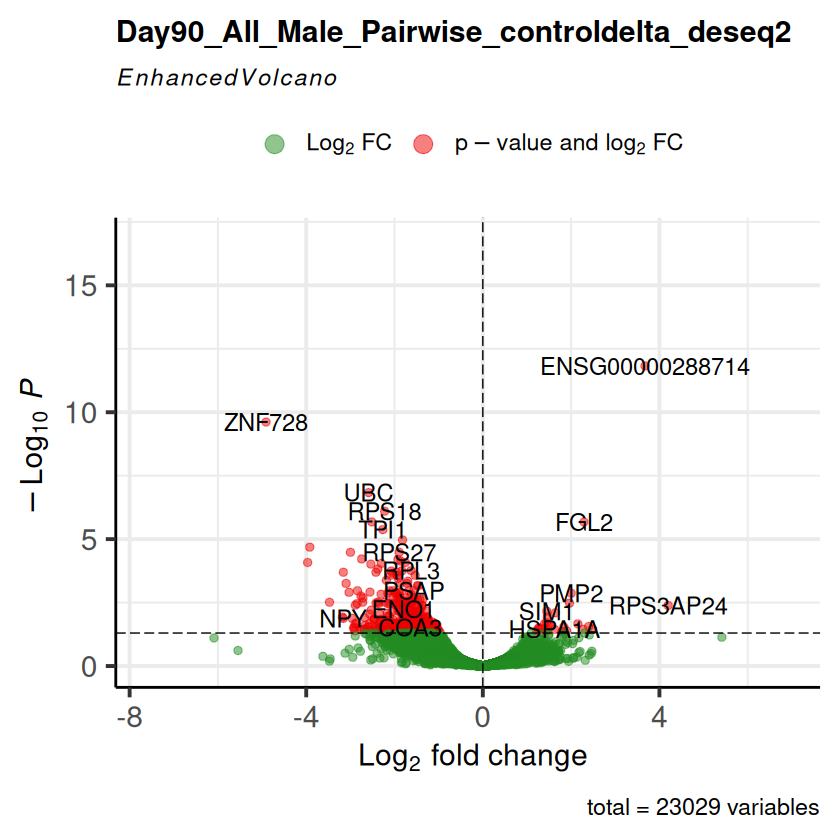

Saving 7 x 7 in image


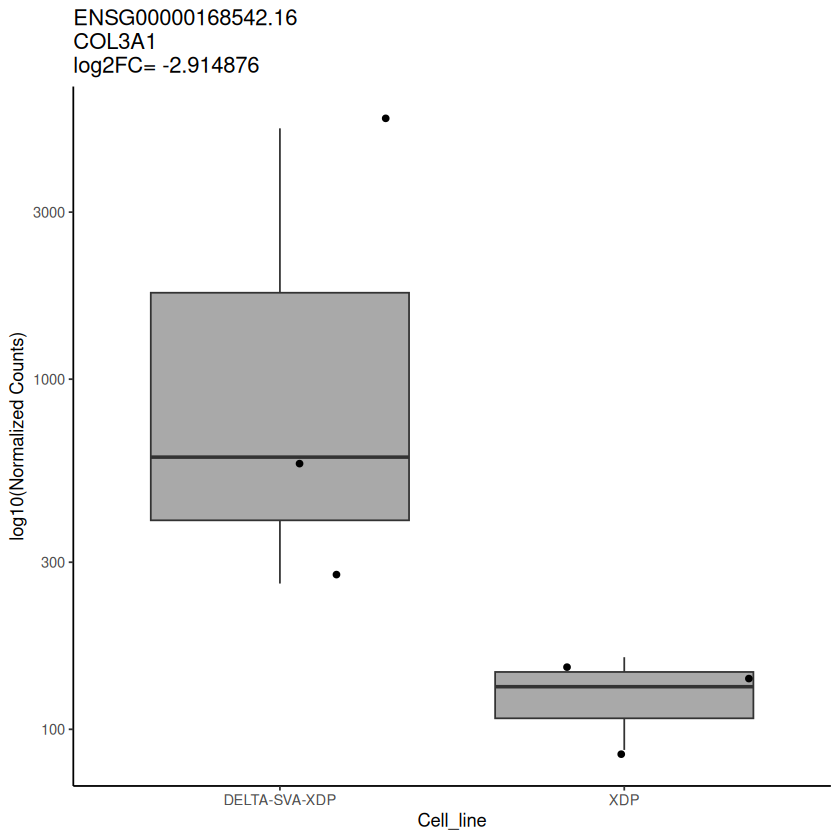

[1] "gene - Day120_All_Male_Pairwise_controlxdp_deseq2"


factor levels were dropped which had no samples



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



final dispersion estimates



fitting model and testing




out of 23979 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 470, 2%
LFC < 0 (down)     : 128, 0.53%
outliers [1]       : 0, 0%
low counts [2]     : 2790, 12%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 23979 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 998, 4.2%
LFC < 0 (down)     : 338, 1.4%
outliers [1]       : 0, 0%
low counts [2]     : 465, 1.9%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 23979 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3080, 13%
LFC < 0 (down)     : 1958, 8.2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


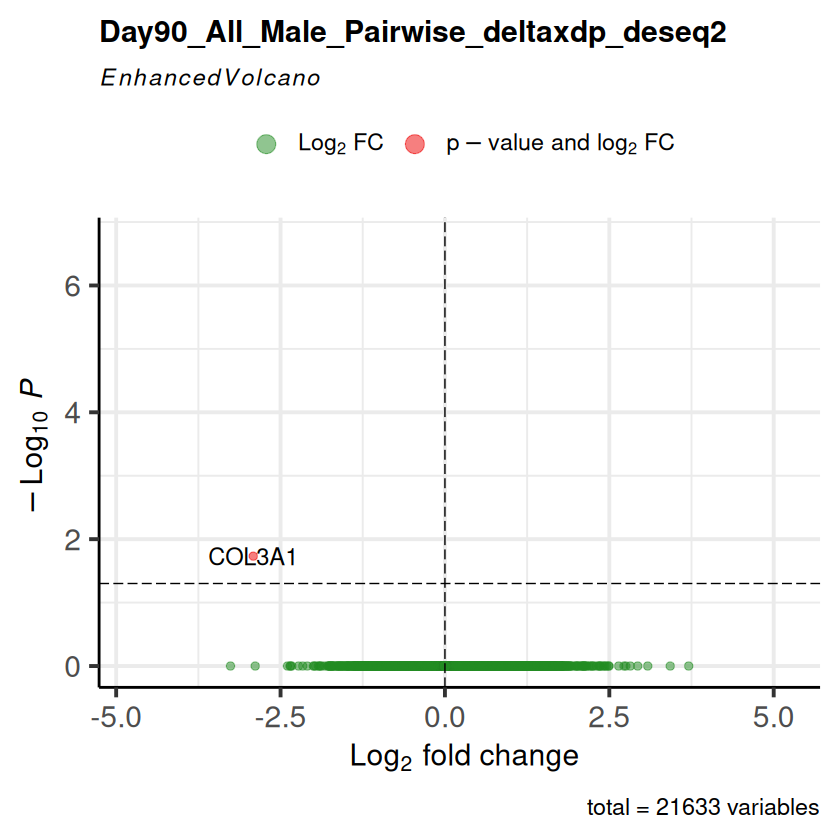

Saving 7 x 7 in image


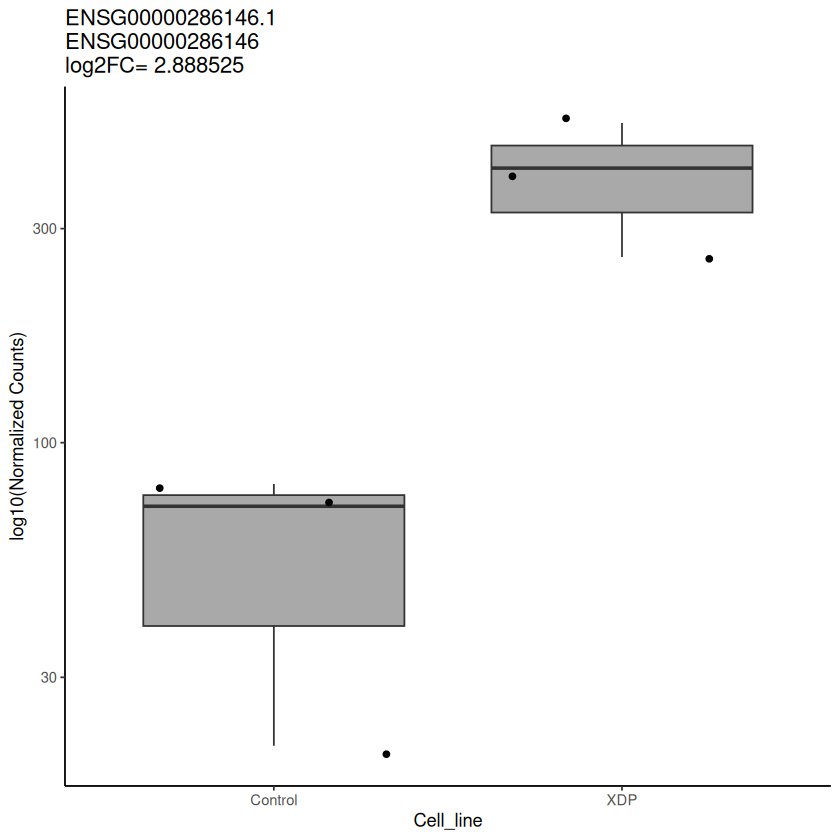

[1] "gene - Day120_All_Male_Pairwise_controldelta_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 23530 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 417, 1.8%
LFC < 0 (down)     : 89, 0.38%
outliers [1]       : 0, 0%
low counts [2]     : 7299, 31%
(mean count < 21)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 23530 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 584, 2.5%
LFC < 0 (down)     : 173, 0.74%
outliers [1]       : 0, 0%
low counts [2]     : 8212, 35%
(mean count < 26)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 23530 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1456, 6.2%
LFC < 0 (down)     : 747, 3.2%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


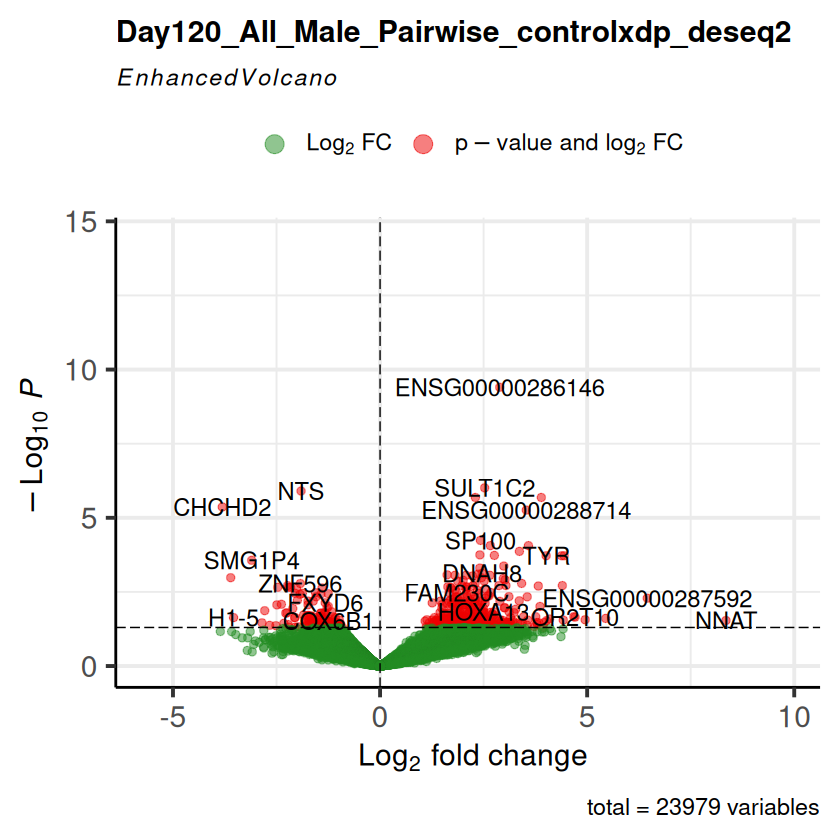

Saving 7 x 7 in image


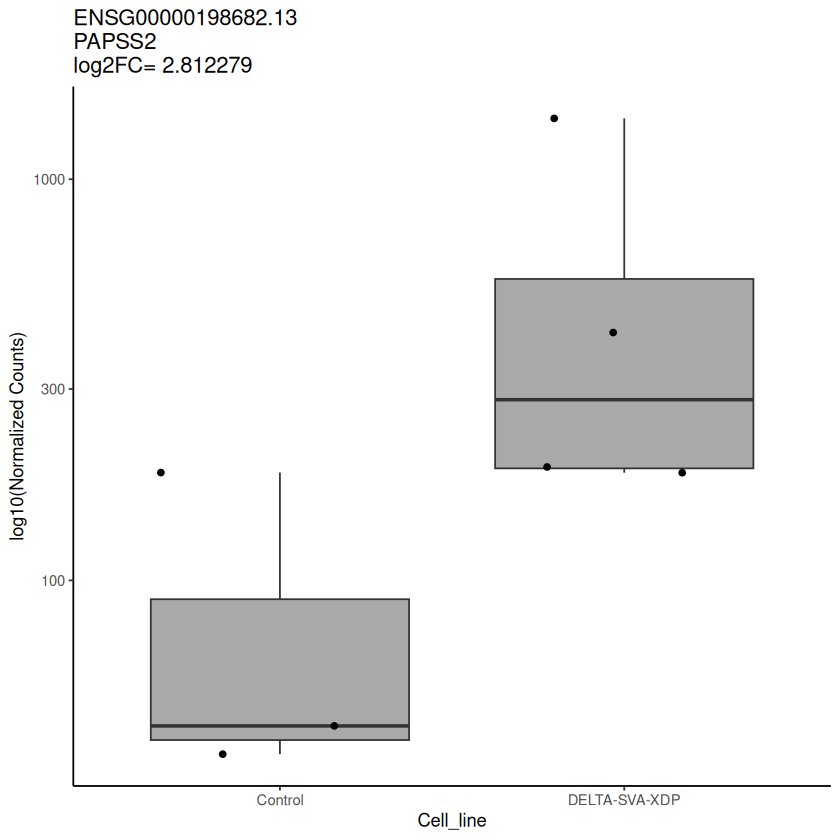

[1] "gene - Day120_All_Male_Pairwise_deltaxdp_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 24444 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 685, 2.8%
LFC < 0 (down)     : 409, 1.7%
outliers [1]       : 0, 0%
low counts [2]     : 2370, 9.7%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24444 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1530, 6.3%
LFC < 0 (down)     : 1258, 5.1%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 24444 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3017, 12%
LFC < 0 (down)     : 3525, 14%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


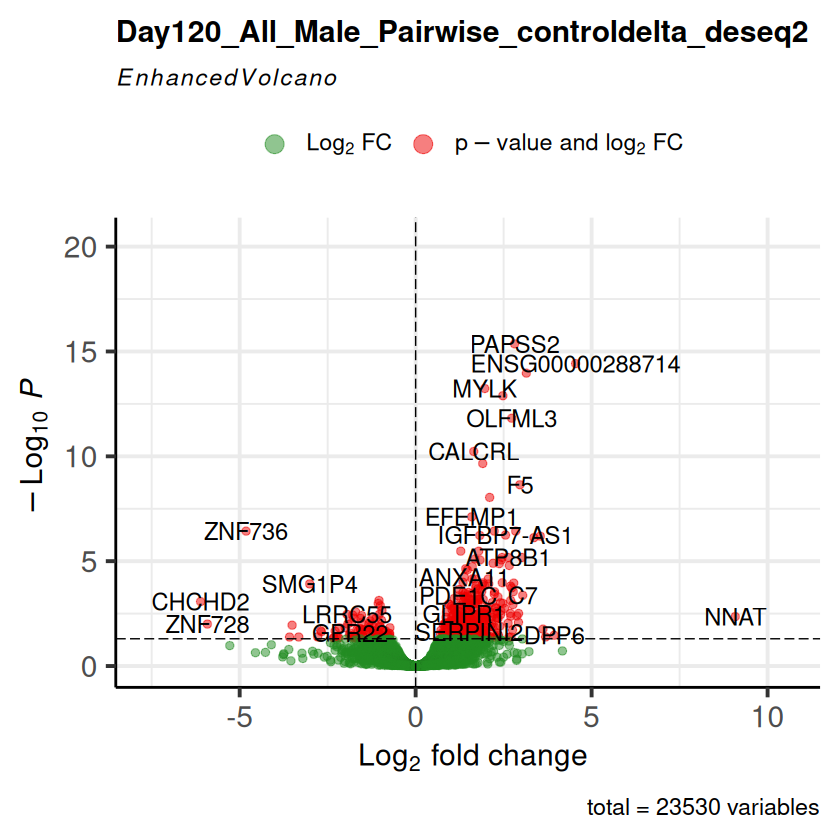

Saving 7 x 7 in image


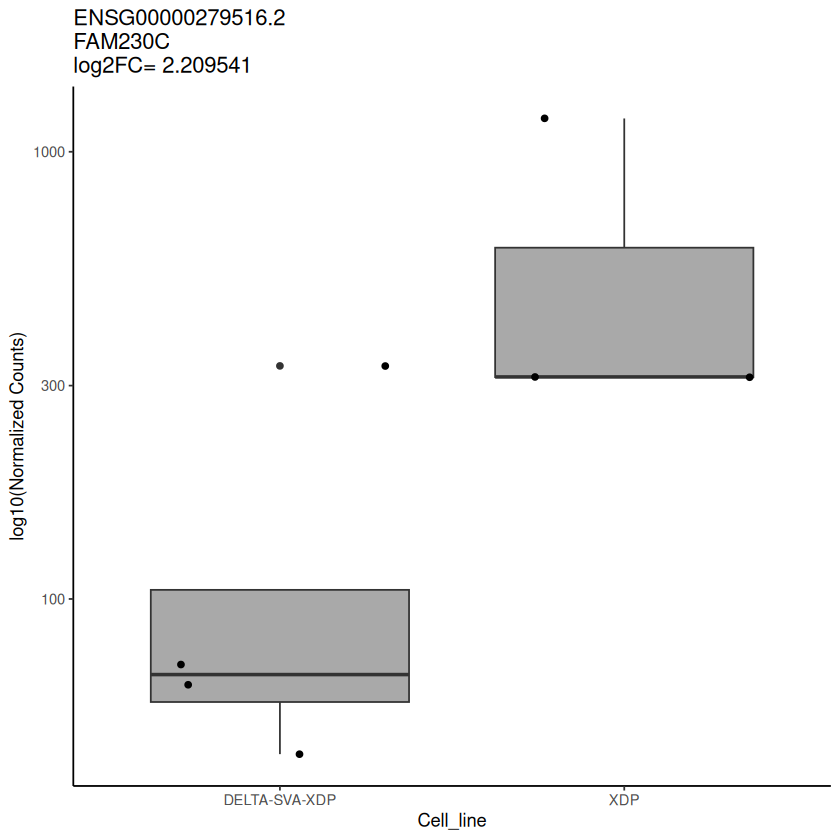

[1] "gene - Mature_organoids_male__ControlxDELTASVA_fullmodel_deseq2"


  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing



2 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest




out of 25699 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 297, 1.2%
LFC < 0 (down)     : 145, 0.56%
outliers [1]       : 0, 0%
low counts [2]     : 9965, 39%
(mean count < 21)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 25699 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 454, 1.8%
LFC < 0 (down)     : 300, 1.2%
outliers [1]       : 0, 0%
low counts [2]     : 8969, 35%
(mean count < 17)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 25699 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1447, 5.6%
LFC < 0 (down)     : 1670, 6.5%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


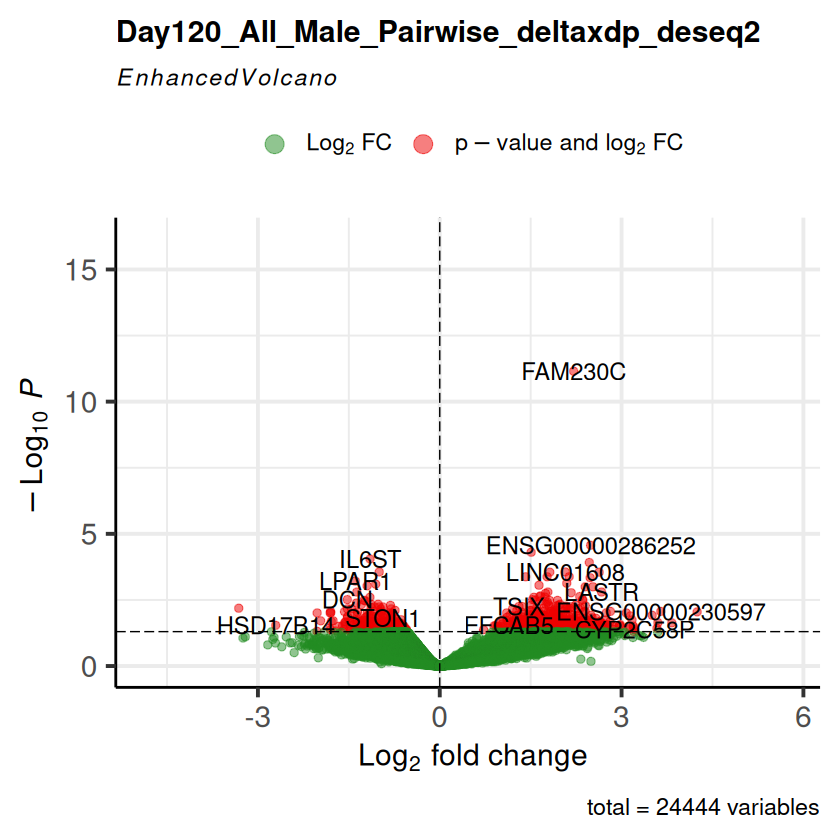

Saving 7 x 7 in image


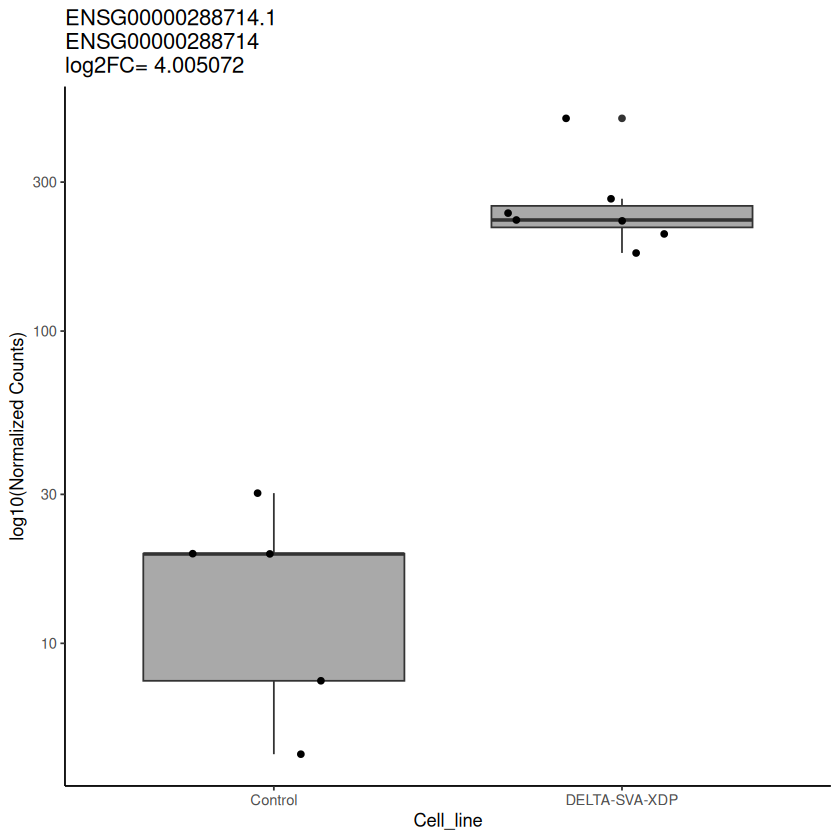

[1] "gene - Mature_organoids_male__ControlxDELTASVA_smallmodel_deseq2"


factor levels were dropped which had no samples



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



using pre-existing size factors



estimating dispersions



gene-wise dispersion estimates



mean-dispersion relationship



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



final dispersion estimates



fitting model and testing




out of 23829 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 107, 0.45%
LFC < 0 (down)     : 79, 0.33%
outliers [1]       : 24, 0.1%
low counts [2]     : 4158, 17%
(mean count < 11)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 23829 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 199, 0.84%
LFC < 0 (down)     : 136, 0.57%
outliers [1]       : 24, 0.1%
low counts [2]     : 6466, 27%
(mean count < 16)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "raw pval"

out of 23829 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1077, 4.5%
LFC < 0 (down)     : 1128, 4.7%
outliers [1]       : 24, 0.1%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Saving 7 x 7 in image


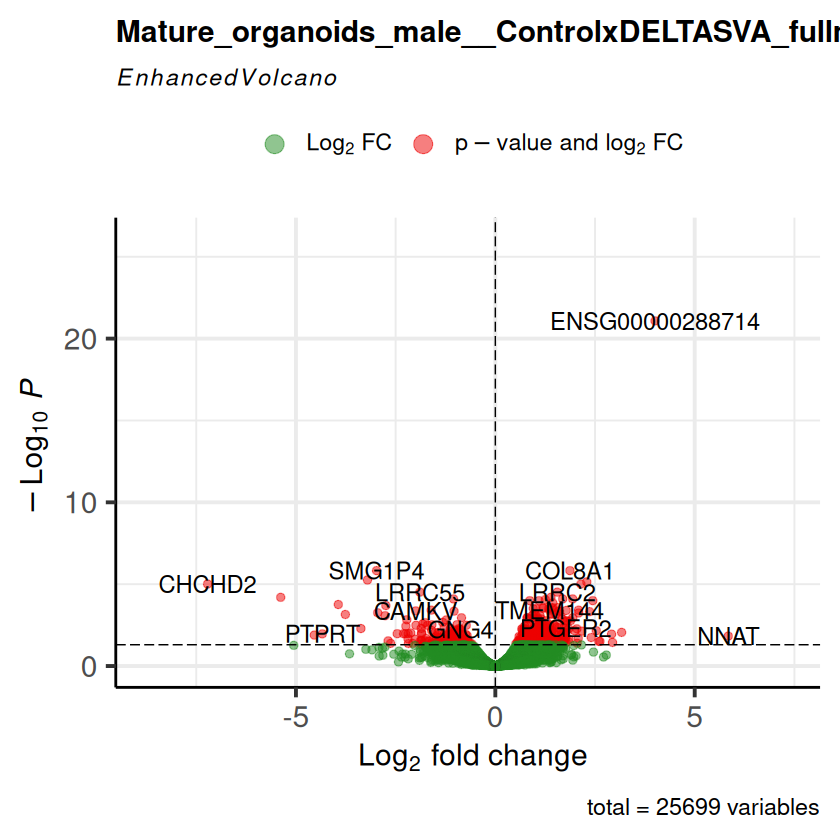

Saving 7 x 7 in image


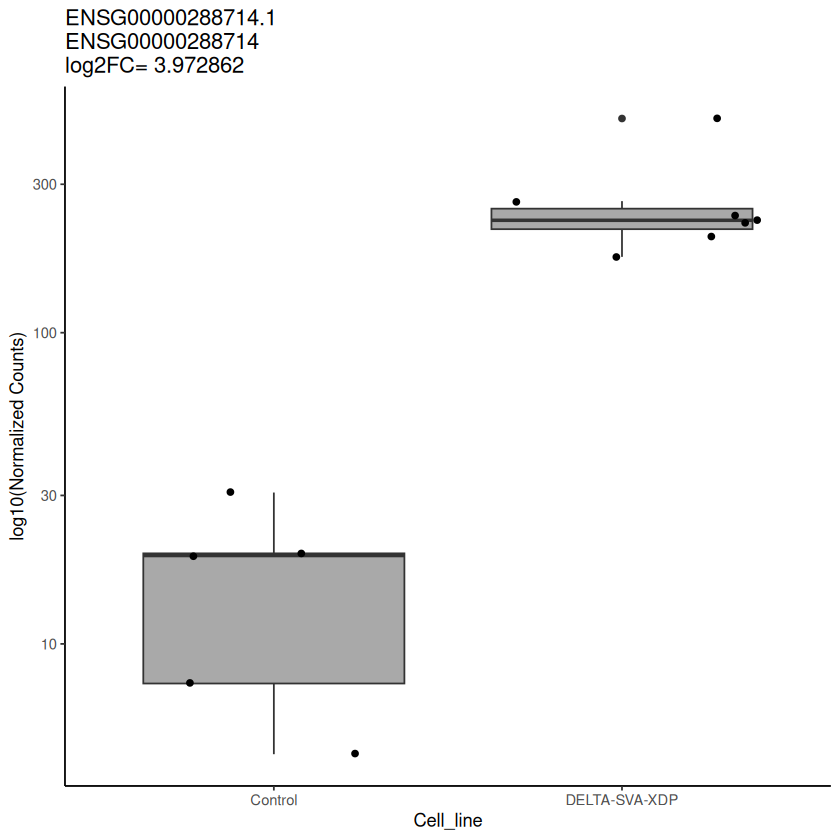

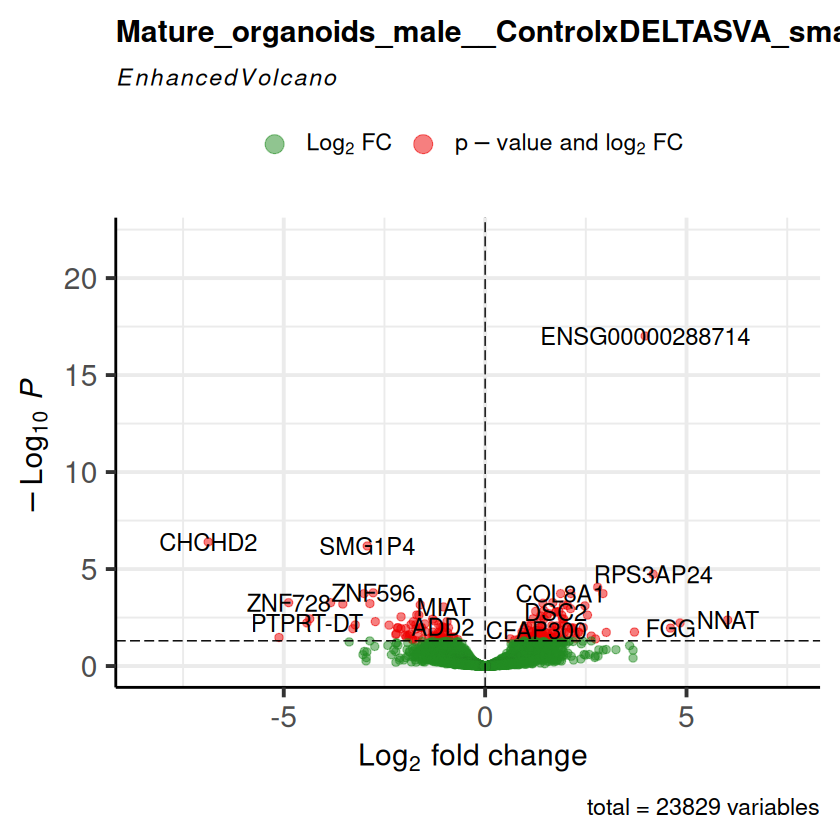

In [14]:
for (rse_var in rse_obj){

    rse_class <- ifelse(grepl('rse_gene',rse_var), 'gene',
                       ifelse(grepl('rse_exon',rse_var), 'exon', 
                            ifelse(grepl('rse_jx',rse_var), 'junction',
                                'transcript')
                              )
                        )

    annotated_rse_obj = merge_with_metadata(rse = get(rse_var), 
                                            metadata_df = metadata)


    for(model in unique(deseq2_model$deseq2)){

        sample_select <- deseq2_model %>%
                                        filter(deseq2 == model)

        sample_ids = colData(annotated_rse_obj) %>% 
                                                as_tibble() %>% 
                                                filter(SAMPLE_ID %in% sample_select$Sample) %>% 
                                                pluck('SAMPLE_ID')

        print(paste0(rse_class, ' - ', sample_select$deseq2[1]))


        a = deseq2_analysis(rse = annotated_rse_obj, 
                            rse_type = rse_class, #gene, kunction or exon rse_obj?
                            sample_ids = sample_ids,
                            #design = ~Cell_line, 
                            design = formula(paste0('~',sample_select$design[1])),
                            #design = ~RIN + Day_of_Maturation + Kit + new_Cell_line, 
                            analysis_name=sample_select$deseq2[1])

        }


}

In [15]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Arch Linux

Matrix products: default
BLAS:   /usr/lib/libblas.so.3.12.0 
LAPACK: /usr/lib/liblapack.so.3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: EST
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] EnhancedVolcano_1.24.0      ggrepel_0.9.6              
 [3] data.table_1.16.4           lubridate_1.9.4            
 [5] forcats_1.0.0               stringr_1.5.1              
 [7] dplyr_1.1.4                 purrr_1.0.2                
 [9] readr_2.1.5        